# Comprehensive Morphological Analysis of Osteocytes: Wildtype vs. LTBP3-Deficient Cells

## Overview
This Jupyter Notebook analyzes the shape and behaviour of osteocytes (bone cells) in 2D cultures, comparing normal (wildtype, or Control) cells to those lacking the LTBP3 gene (mutant). LTBP3 affects a protein (TGF-β) that helps maintain bone strength and cell function. When LTBP3 is missing, cells may grow larger (hypertrophy) and develop more branches (dendrites), which could impact how bones sense and respond to stress. In this projets, the cell features like size, shape, intensity, and branching were measured and their changes over time (every hour) were tracked. The goal is to test if LTBP3-deficient cells are larger and have more branches due to changes in cell structure. The code is simple, efficient, and produces clear, high-quality images (300 DPI) for the thesis.

### Feature Definitions and Importance
Several features are analyzed to understand differences between Control and LTBP3-deficient cells. Here’s what each feature means and why it matters:
- **cell_id**: A unique number for each cell, enabling tracking across frames.
- **area**: The size of the cell (in pixels²). Larger areas in LTBP3-deficient cells suggest hypertrophy.
- **mean_intensity**: The average brightness of the cell in images, which might show differences in cell structure or staining.
- **eccentricity**: How stretched out the cell is (0 = round, 1 = very elongated). Higher values in mutants may mean more branching.
- **perimeter**: The length of the cell’s outer edge (in pixels). A longer perimeter in mutants suggests more complex or branched shapes.
- **major_axis_length**, **minor_axis_length**: The lengths of the cell’s longest and shortest axes. These help understand cell shape and stretching.
- **convex_area**: The area of a shape that tightly wraps the cell. Comparing this to the cell’s area shows how irregular the shape is.
- **bbox_area**: The area of a rectangle that fits around the cell. It shows how much space the cell takes up.
- **equivalent_diameter**:  The diameter of a circle with the same area as the cell. This measures size in a way that ignores shape differences.
- **extent**: The ratio of the cell’s area to its bounding box area. Lower values mean the cell has an irregular shape.
- **fractal_dimension**: How complex the cell’s edge is. Higher values in mutants may indicate more branching.
- **form_factor**: Ratio of area to perimeter², indicating circularity. Lower values suggest irregular shapes.
- **solidity**: Ratio of area to convex_area. Lower values indicate irregular shapes.
- **compactness**: Ratio of perimeter² to area. Higher values indicate complex boundaries.
- **dendrite_count**: The number of branches (dendrites) on the cell, important for how cells communicate in bones.
- **is_dendritic**: A yes/no flag for whether the cell has branches. Helps identify branched cells.
- **frame_idx**: The video frame number (1-hour intervals), enabling temporal analysis.
- **condition**: Whether the cell is Control (wildtype) or LTBP3-deficient (mutant), the main comparison.
- **video_name**: Identifier for video data, ensuring correct data grouping.

In [1]:
# Import libraries
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Ellipse
from scipy.stats import mannwhitneyu, shapiro, norm
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import networkx as nx
from skimage.measure import regionprops
import imageio.v3 as imageio
import glob
import logging
from scipy.optimize import linear_sum_assignment

# Set seed for reproducibility
np.random.seed(42)

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Define paths
results_dir = Path('../results')
metrics_dir = results_dir / 'metrics'
wildtype_dir = metrics_dir / 'wildtype'
mutant_dir = metrics_dir / 'mutant'
morph_dir = results_dir / 'morph_plots'
data_dir = Path('../data/processed')

# Create directories
results_dir.mkdir(exist_ok=True)
morph_dir.mkdir(exist_ok=True)

# Define features
size_features = ['area', 'convex_area', 'bbox_area', 'equivalent_diameter', 'perimeter']
shape_features = ['extent', 'eccentricity', 'form_factor', 'solidity', 'compactness', 'fractal_dimension']
intensity_features = ['mean_intensity', 'major_axis_length', 'minor_axis_length']
dendritic_features = ['dendrite_count', 'is_dendritic']
features = size_features + shape_features + intensity_features + dendritic_features

# Define video names
wildtype_video = 'Confluence_Single movie_30.03.2025_no mask_C2_3'
mutant_video = 'Confluence_Single movie_30.03.2025_no mask_G2_1'

# List available TIFF files for debugging
tiff_files = glob.glob(str(data_dir / '**' / '*.tif'), recursive=True)
print('Available TIFF files:')
for f in tiff_files:
    print(f'  {f}')

Available TIFF files:
  ../data/processed/wildtype/Confluence_Single movie_30.03.2025_no mask_C5_2/frame_0026/wildtype_Confluence_Single movie_30.03.2025_no mask_C5_2_frame_0026_combined.tif
  ../data/processed/wildtype/Confluence_Single movie_30.03.2025_no mask_C5_2/frame_0026/wildtype_Confluence_Single movie_30.03.2025_no mask_C5_2_frame_0026_labeled.tif
  ../data/processed/wildtype/Confluence_Single movie_30.03.2025_no mask_C5_2/frame_0026/wildtype_Confluence_Single movie_30.03.2025_no mask_C5_2_frame_0026_filtered.tif
  ../data/processed/wildtype/Confluence_Single movie_30.03.2025_no mask_C5_2/frame_0019/wildtype_Confluence_Single movie_30.03.2025_no mask_C5_2_frame_0019_labeled.tif
  ../data/processed/wildtype/Confluence_Single movie_30.03.2025_no mask_C5_2/frame_0019/wildtype_Confluence_Single movie_30.03.2025_no mask_C5_2_frame_0019_filtered.tif
  ../data/processed/wildtype/Confluence_Single movie_30.03.2025_no mask_C5_2/frame_0019/wildtype_Confluence_Single movie_30.03.2025_no 

## 1. Data Loading and Quality Check

**Purpose**: Load cell data from files, make sure it’s correct, and check for any issues.

**Method**:
- Read data from CSV files for normal (Control) and LTBP3-deficient (mutant) cells, adding labels for condition (Control or LTBP3) and video name.
- Combine all data and keep only the important features (like cell size and shape).
- Check for missing or incorrect data and log warnings if any are found.
- Use a method (IQR) to find outliers, which might be cells that are dividing or errors in the images.

**Why Important**: This step ensures the data is complete and accurate before analysis. Finding outliers helps avoid mistakes in results, as they could be unusual cells or imaging problems.

In [20]:
# Function to load CSV files
def load_csvs_from_dir(directory: Path, condition: str) -> pd.DataFrame:
    dfs = []
    for csv_path in directory.glob('*.csv'):
        try:
            df = pd.read_csv(csv_path)
            if 'frame_idx' not in df.columns:
                logger.warning(f'Skipping {csv_path}: Missing "frame_idx" column. Assigning default frame_idx=0.')
                df['frame_idx'] = 0
            df['condition'] = condition
            df['video_name'] = csv_path.stem.replace('_metrics', '')
            df['frame_idx'] = df['frame_idx'].astype(np.int64)
            dfs.append(df)
        except Exception as e:
            logger.error(f'Error reading {csv_path}: {e}')
    if dfs:
        return pd.concat(dfs, ignore_index=True)
    else:
        logger.warning(f'No valid CSV files found in {directory}.')
        return pd.DataFrame()

# Load data
df_wildtype = load_csvs_from_dir(wildtype_dir, 'Control')
df_mutant = load_csvs_from_dir(mutant_dir, 'LTBP3')

# Check for empty data
if df_wildtype.empty and df_mutant.empty:
    raise ValueError('No valid CSV files found. Please run main_workflow.py to generate metrics.')

# Combine data and filter for relevant features
df_all = pd.concat([df_wildtype, df_mutant], ignore_index=True)
df_features = df_all[features + ['condition', 'frame_idx', 'video_name', 'cell_id']].dropna()

# Data quality check
print('Data Quality Check:')
print(f'Total samples: {len(df_features)} (Control: {len(df_features[df_features["condition"] == "Control"])}, LTBP3: {len(df_features[df_features["condition"] == "LTBP3"])})')
print('Missing values per feature:')
print(df_features.isna().sum())

Data Quality Check:
Total samples: 12163 (Control: 5303, LTBP3: 6860)
Missing values per feature:
area                   0
convex_area            0
bbox_area              0
equivalent_diameter    0
perimeter              0
extent                 0
eccentricity           0
form_factor            0
solidity               0
compactness            0
fractal_dimension      0
mean_intensity         0
major_axis_length      0
minor_axis_length      0
dendrite_count         0
is_dendritic           0
condition              0
frame_idx              0
video_name             0
cell_id                0
dtype: int64


In [19]:
# Outlier detection using IQR method
def detect_outliers(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)][feature]
    return len(outliers)
    
outlier_counts = {f: detect_outliers(df_features, f) for f in features if f != 'is_dendritic'}
print('Outliers per feature (IQR method):')
for f, count in outlier_counts.items():
    print(f'  {f}: {count} outliers')

Outliers per feature (IQR method):
  area: 710 outliers
  convex_area: 811 outliers
  bbox_area: 874 outliers
  equivalent_diameter: 391 outliers
  perimeter: 620 outliers
  extent: 15 outliers
  eccentricity: 306 outliers
  form_factor: 0 outliers
  solidity: 207 outliers
  compactness: 591 outliers
  fractal_dimension: 179 outliers
  mean_intensity: 184 outliers
  major_axis_length: 594 outliers
  minor_axis_length: 506 outliers
  dendrite_count: 226 outliers


## 2. Statistical Analysis of Cell Features

**Purpose**: This section summarizes and compares the features (like size and shape) of normal (Control) and LTBP3-deficient (mutant) cells using statistics. It checks if the data follows a normal pattern and measures how big the differences are between the two groups.

**Method**:
- Calculate the average and spread (mean and standard deviation) for each cell feature, such as area and perimeter, for Control and LTBP3-deficient cells.
- Use the Shapiro-Wilk test to see if the data looks like a bell curve (normal distribution). Since cell data often isn’t normal, the Mann-Whitney U test is used to compare Control and LTBP3 cells.
- Adjust results with a Bonferroni correction to avoid mistakes when testing many features.
- Measure the size of differences using Cohen’s d, where:
  - Small difference: less than 0.2
  - Medium difference: 0.2 to 0.5
  - Large difference: 0.5 or more
- Add a 95% confidence interval to show how reliable the Cohen’s d value is.
- Save all results to a CSV file.

**Why Important**: This analysis shows if differences in cell features (like larger size or more branching in LTBP3-deficient cells) are real and meaningful. It uses tests that work well for biological data, ensuring trustworthy results for the thesis.


In [3]:
# Normality test
print('Shapiro-Wilk Normality Test (p-values):')
for f in features:
    control_data = df_features[df_features['condition'] == 'Control'][f]
    ltbp3_data = df_features[df_features['condition'] == 'LTBP3'][f]
    control_p = shapiro(control_data)[1] if len(control_data) <= 5000 else shapiro(control_data.sample(5000, random_state=42))[1]
    ltbp3_p = shapiro(ltbp3_data)[1] if len(ltbp3_data) <= 5000 else shapiro(ltbp3_data.sample(5000, random_state=42))[1]
    print(f'  {f}: Control p={control_p:.2e}, LTBP3 p={ltbp3_p:.2e}')

# Compute statistics
def cohens_d(g1, g2):
    mean_diff = g1.mean() - g2.mean()
    pooled_var = (g1.var() + g2.var()) / 2
    return mean_diff / np.sqrt(pooled_var) if pooled_var > 0 else 0

def cohens_d_ci(g1, g2, alpha=0.05):
    d = cohens_d(g1, g2)
    n1, n2 = len(g1), len(g2)
    se = np.sqrt((n1 + n2) / (n1 * n2) + d**2 / (2 * (n1 + n2))) if (n1 + n2) > 0 else 0
    z = norm.ppf(1 - alpha/2)
    return d - z * se, d + z * se

stats_data = []
p_values = []
for f in features:
    control_data = df_features[df_features['condition'] == 'Control'][f]
    ltbp3_data = df_features[df_features['condition'] == 'LTBP3'][f]
    if len(control_data) > 0 and len(ltbp3_data) > 0:
        p_values.append(mannwhitneyu(control_data, ltbp3_data)[1])
    else:
        p_values.append(np.nan)

p_adjusted = multipletests(p_values, method='bonferroni')[1]

for i, f in enumerate(features):
    control_data = df_features[df_features['condition'] == 'Control'][f]
    ltbp3_data = df_features[df_features['condition'] == 'LTBP3'][f]
    d = cohens_d(ltbp3_data, control_data) if len(control_data) > 0 and len(ltbp3_data) > 0 else np.nan
    d_ci_low, d_ci_high = cohens_d_ci(ltbp3_data, control_data) if len(control_data) > 0 and len(ltbp3_data) > 0 else (np.nan, np.nan)
    stats_data.append({
        'Feature': f,
        'Control Mean': control_data.mean() if len(control_data) > 0 else np.nan,
        'Control Std': control_data.std() if len(control_data) > 0 else np.nan,
        'LTBP3 Mean': ltbp3_data.mean() if len(ltbp3_data) > 0 else np.nan,
        'LTBP3 Std': ltbp3_data.std() if len(ltbp3_data) > 0 else np.nan,
        'Adjusted p-value': p_adjusted[i],
        "Cohen's d": d,
        "Cohen's d 95% CI": f'[{d_ci_low:.2f}, {d_ci_high:.2f}]' if not np.isnan(d) else '[NaN, NaN]',
        'Significance': '***' if p_adjusted[i] < 0.001 else '**' if p_adjusted[i] < 0.01 else '*' if p_adjusted[i] < 0.05 else 'ns',
        'Effect Size Interpretation': 'Large' if abs(d) > 0.5 else 'Medium' if abs(d) > 0.2 else 'Small' if not np.isnan(d) else 'N/A'
    })

stats_df = pd.DataFrame(stats_data)
print('Statistical Summary:')
display(stats_df)
stats_df.to_csv(morph_dir / 'stats_summary.csv', index=False)

# Interpretation
print('Interpretation:')
print('Significant p-values (<0.05) indicate differences between conditions. Large Cohen’s d values (|d|>0.5) suggest biologically meaningful differences, e.g., in size (area, perimeter) or branching (dendrite_count, fractal_dimension). Non-normal distributions (low Shapiro-Wilk p-values) justify the use of Mann-Whitney U tests.')

Shapiro-Wilk Normality Test (p-values):
  area: Control p=1.28e-66, LTBP3 p=3.58e-66
  convex_area: Control p=9.81e-71, LTBP3 p=6.88e-69
  bbox_area: Control p=4.81e-71, LTBP3 p=5.62e-70
  equivalent_diameter: Control p=6.50e-51, LTBP3 p=1.12e-53
  perimeter: Control p=2.75e-60, LTBP3 p=4.08e-59
  extent: Control p=4.18e-14, LTBP3 p=9.71e-10
  eccentricity: Control p=9.61e-47, LTBP3 p=3.83e-48
  form_factor: Control p=1.37e-16, LTBP3 p=2.84e-15
  solidity: Control p=4.74e-43, LTBP3 p=1.43e-38
  compactness: Control p=4.11e-59, LTBP3 p=2.75e-54
  fractal_dimension: Control p=2.08e-24, LTBP3 p=2.72e-16
  mean_intensity: Control p=1.12e-11, LTBP3 p=5.61e-03
  major_axis_length: Control p=1.47e-55, LTBP3 p=3.04e-56
  minor_axis_length: Control p=3.45e-54, LTBP3 p=1.30e-47
  dendrite_count: Control p=4.91e-75, LTBP3 p=5.08e-77
  is_dendritic: Control p=7.78e-77, LTBP3 p=1.48e-77
Statistical Summary:


Feature  Control Mean  Control Std  LTBP3 Mean   LTBP3 Std  \
0                  area    143.524420   101.293642  105.668367   62.407026   
1           convex_area    182.884216   150.172813  135.301458   89.329642   
2             bbox_area    276.486706   250.381634  201.647230  146.470218   
3   equivalent_diameter     12.927116     3.953934   11.236125    2.879557   
4             perimeter     53.476793    24.913139   45.557610   17.535114   
5                extent      0.578561     0.126415    0.562794    0.122490   
6          eccentricity      0.792313     0.148581    0.801647    0.142943   
7           form_factor      0.656190     0.181748    0.662082    0.174010   
8              solidity      0.819448     0.093272    0.802926    0.096768   
9           compactness      1.680242     0.620023    1.641256    0.537365   
10    fractal_dimension      1.628686     0.063032    1.660231    0.065314   
11       mean_intensity      0.531541     0.027226    0.516295    0.032433   
12    major_axis_length     19.631498     8.656571   17.208411    6.638771   
13    minor_axis_length     10.060914     3.561414    8.727474    2.618075   
14       dendrite_count      0.423534     0.773079    0.360641    0.688753   
15         is_dendritic      0.291910     0.454684    0.274781    0.446437   

    Adjusted p-value  Cohen's d Cohen's d 95% CI Significance  \
0      2.386651e-149  -0.449982   [-0.49, -0.41]          ***   
1      9.800211e-106  -0.385114   [-0.42, -0.35]          ***   
2       4.425542e-77  -0.364866   [-0.40, -0.33]          ***   
3      2.386651e-149  -0.488907   [-0.53, -0.45]          ***   
4       1.562085e-82  -0.367610   [-0.40, -0.33]          ***   
5       1.426566e-11  -0.126676   [-0.16, -0.09]          ***   
6       4.596529e-02   0.064025     [0.03, 0.10]            *   
7       1.000000e+00   0.033115    [-0.00, 0.07]           ns   
8       1.078012e-22  -0.173849   [-0.21, -0.14]          ***   
9       1.000000e+00  -0.067197   [-0.10, -0.03]           ns   
10     3.648424e-156   0.491497     [0.46, 0.53]          ***   
11     1.105758e-146  -0.509167   [-0.55, -0.47]          ***   
12      2.066361e-57  -0.314118   [-0.35, -0.28]          ***   
13     2.998152e-115  -0.426627   [-0.46, -0.39]          ***   
14      3.548088e-02  -0.085903   [-0.12, -0.05]            *   
15      5.986759e-01  -0.038015   [-0.07, -0.00]           ns   

   Effect Size Interpretation  
0                      Medium  
1                      Medium  
2                      Medium  
3                      Medium  
4                      Medium  
5                       Small  
6                       Small  
7                       Small  
8                       Small  
9                       Small  
10                     Medium  
11                      Large  
12                     Medium  
13                     Medium  
14                      Small  
15                      Small

Interpretation:
Significant p-values (<0.05) indicate differences between conditions. Large Cohen’s d values (|d|>0.5) suggest biologically meaningful differences, e.g., in size (area, perimeter) or branching (dendrite_count, fractal_dimension). Non-normal distributions (low Shapiro-Wilk p-values) justify the use of Mann-Whitney U tests.


## 3. Cell Tracking Across Frames

**Purpose**: Track individual cells across frames to analyze temporal changes in morphology, enhancing understanding of dynamic differences between conditions.

**Method**:
- Use centroid-based tracking with Hungarian algorithm (linear sum assignment) to match cells between consecutive frames based on centroid distance.
- Compute changes in area and perimeter for tracked cells.
- Visualize trajectories of selected cells to show movement and morphological changes.

**Why Important**: Tracking reveals how individual cells evolve over time, potentially showing dynamic hypertrophy or branching in LTBP3-deficient cells. This is critical for understanding temporal effects of LTBP3 deficiency.

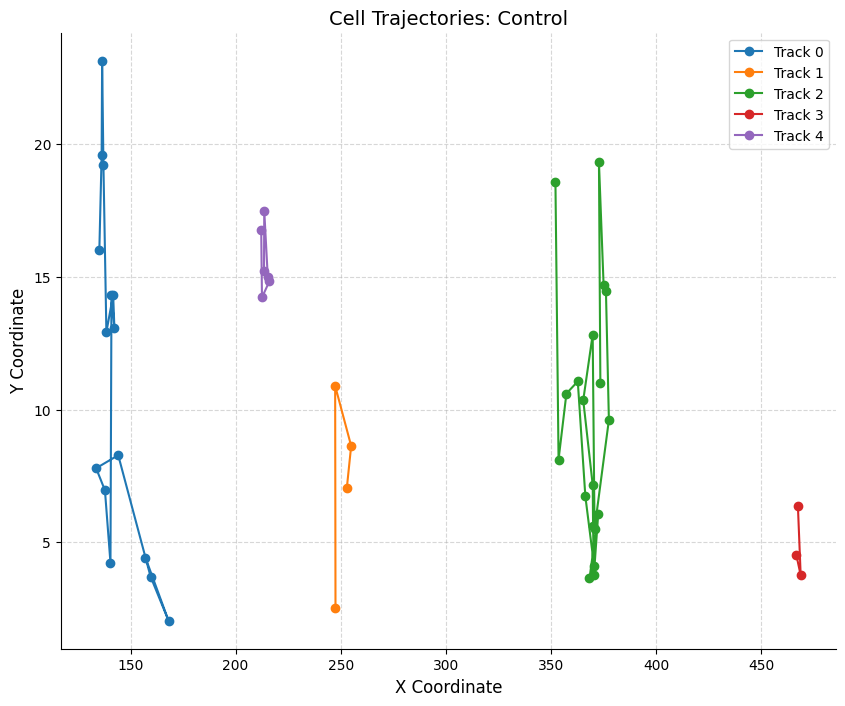

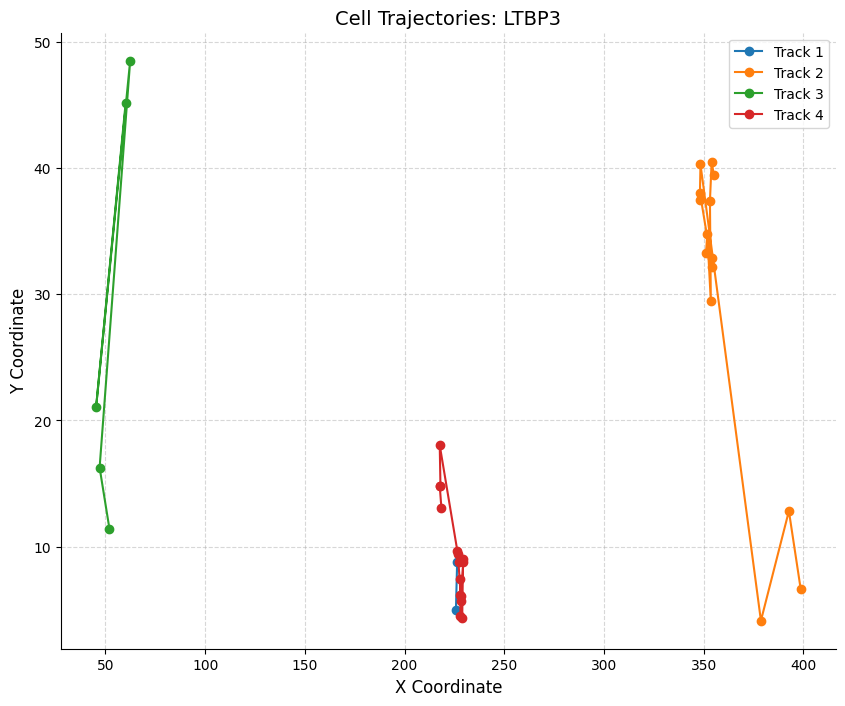

Morphological Changes (Sample):


track_id  frame_from  frame_to  area_change  perimeter_change
0         0           0         1        -63.0        -14.863961
1         0           1         2         20.0         10.656854
2         0           2         3        -26.0        -15.828427
3         0           3         4        129.0         39.798990
4         0           4         5        -17.0        -13.313708

track_id  frame_from  frame_to  area_change  perimeter_change
0         1           0         1         17.0          5.899495
1         2           0         1       -140.0        -29.035534
2         2           1         2         88.0         19.514719
3         2           2         3       -107.0        -17.964466
4         2           3         4        -20.0         -8.863961

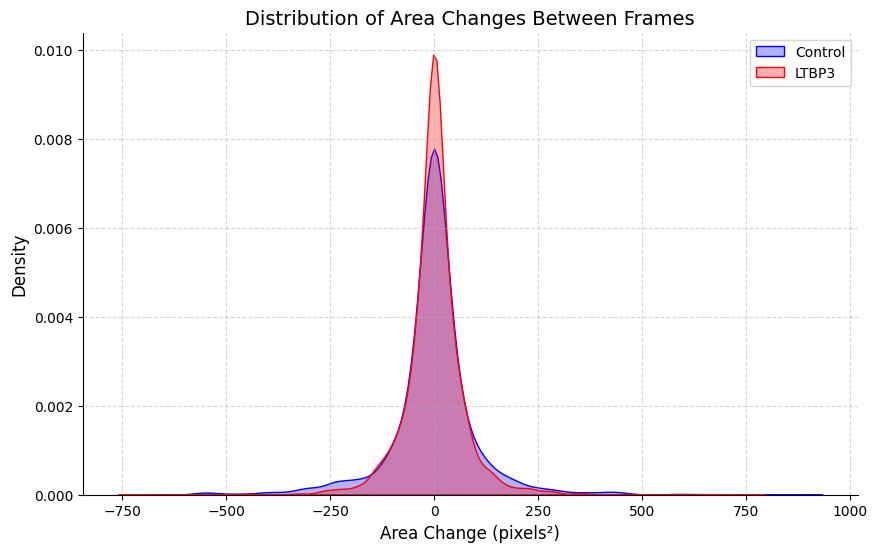

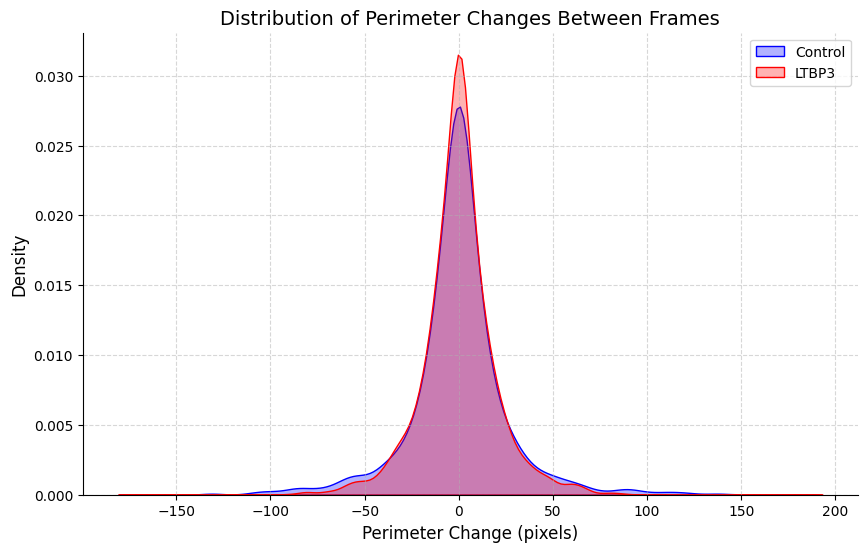

Interpretation:
Trajectories show cell movement, with LTBP3-deficient cells potentially exhibiting greater morphological changes (area, perimeter) due to dynamic cytoskeletal remodeling. KDE plots indicate the distribution of changes, with wider distributions suggesting more variability in LTBP3-deficient cells.


In [4]:
# Function to extract centroids from labeled images
def get_centroids(labeled_image, metrics_df, frame_idx):
    regions = regionprops(labeled_image)
    df_frame = metrics_df[metrics_df['frame_idx'] == frame_idx]
    centroids = []
    cell_ids = df_frame['cell_id'].values
    for region in regions:
        if region.label in df_frame['cell_id'].values:
            centroids.append(region.centroid)
    return np.array(centroids), cell_ids

# Function to track cells
def track_cells(df, condition, video_name):
    df_cond = df[(df['condition'] == condition) & (df['video_name'] == video_name)].copy()
    frames = sorted(df_cond['frame_idx'].unique())
    tracks = {}
    track_id = 0

    for i in range(len(frames) - 1):
        frame_curr = frames[i]
        frame_next = frames[i + 1]
        folder_name = 'wildtype' if condition == 'Control' else 'mutant'
        curr_path = data_dir / folder_name / video_name / f'frame_{frame_curr:04d}' / f'{folder_name}_{video_name}_frame_{frame_curr:04d}_labeled.tif'
        next_path = data_dir / folder_name / video_name / f'frame_{frame_next:04d}' / f'{folder_name}_{video_name}_frame_{frame_next:04d}_labeled.tif'

        if not (curr_path.exists() and next_path.exists()):
            logger.warning(f'Missing images for frames {frame_curr} or {frame_next} in {condition}.')
            continue

        labeled_curr = imageio.imread(curr_path)
        labeled_next = imageio.imread(next_path)
        centroids_curr, ids_curr = get_centroids(labeled_curr, df_cond, frame_curr)
        centroids_next, ids_next = get_centroids(labeled_next, df_cond, frame_next)

        if len(centroids_curr) == 0 or len(centroids_next) == 0:
            logger.warning(f'No centroids found for frame {frame_curr} or {frame_next} in {condition}.')
            continue

        # Compute distance matrix
        distances = np.sqrt(((centroids_curr[:, None] - centroids_next) ** 2).sum(axis=2))
        row_ind, col_ind = linear_sum_assignment(distances)

        # Assign track IDs
        if i == 0:
            for idx in range(len(ids_curr)):
                tracks[track_id] = [{'frame_idx': frame_curr, 'cell_id': ids_curr[idx], 'centroid': centroids_curr[idx]}]
                track_id += 1

        for r, c in zip(row_ind, col_ind):
            if distances[r, c] < 50:  # Threshold to avoid large jumps
                for t in tracks:
                    if tracks[t][-1]['frame_idx'] == frame_curr and tracks[t][-1]['cell_id'] == ids_curr[r]:
                        tracks[t].append({'frame_idx': frame_next, 'cell_id': ids_next[c], 'centroid': centroids_next[c]})
                        break
        # Start new tracks for unmatched cells
        unmatched = set(range(len(ids_next))) - set(col_ind)
        for c in unmatched:
            tracks[track_id] = [{'frame_idx': frame_next, 'cell_id': ids_next[c], 'centroid': centroids_next[c]}]
            track_id += 1

    return tracks

# Track cells for both conditions
tracks_control = track_cells(df_features, 'Control', wildtype_video)
tracks_ltbp3 = track_cells(df_features, 'LTBP3', mutant_video)

# Visualize trajectories for a subset of cells
def plot_trajectories(tracks, condition, output_path, max_tracks=5):
    plt.figure(figsize=(10, 8))
    for track_id in list(tracks.keys())[:max_tracks]:
        track = tracks[track_id]
        if len(track) > 1:
            x = [point['centroid'][1] for point in track]
            y = [point['centroid'][0] for point in track]
            plt.plot(x, y, marker='o', label=f'Track {track_id}')
    plt.title(f'Cell Trajectories: {condition}', fontsize=14)
    plt.xlabel('X Coordinate', fontsize=12)
    plt.ylabel('Y Coordinate', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    sns.despine()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

plot_trajectories(tracks_control, 'Control', morph_dir / 'trajectories_control.png')
plot_trajectories(tracks_ltbp3, 'LTBP3', morph_dir / 'trajectories_ltbp3.png')

# Compute morphological changes for tracked cells
def compute_morph_changes(tracks, df):
    changes = []
    for track_id, track in tracks.items():
        if len(track) > 1:
            for i in range(len(track) - 1):
                curr = df[(df['frame_idx'] == track[i]['frame_idx']) & (df['cell_id'] == track[i]['cell_id'])]
                next = df[(df['frame_idx'] == track[i+1]['frame_idx']) & (df['cell_id'] == track[i+1]['cell_id'])]
                if not (curr.empty or next.empty):
                    area_change = next['area'].iloc[0] - curr['area'].iloc[0]
                    perimeter_change = next['perimeter'].iloc[0] - curr['perimeter'].iloc[0]
                    changes.append({
                        'track_id': track_id,
                        'frame_from': track[i]['frame_idx'],
                        'frame_to': track[i+1]['frame_idx'],
                        'area_change': area_change,
                        'perimeter_change': perimeter_change
                    })
    return pd.DataFrame(changes)

changes_control = compute_morph_changes(tracks_control, df_features[df_features['condition'] == 'Control'])
changes_ltbp3 = compute_morph_changes(tracks_ltbp3, df_features[df_features['condition'] == 'LTBP3'])

print('Morphological Changes (Sample):')
display(changes_control.head())
display(changes_ltbp3.head())

# Visualize changes
plt.figure(figsize=(10, 6))
sns.kdeplot(data=changes_control, x='area_change', label='Control', color='blue', fill=True, alpha=0.3)
sns.kdeplot(data=changes_ltbp3, x='area_change', label='LTBP3', color='red', fill=True, alpha=0.3)
plt.title('Distribution of Area Changes Between Frames', fontsize=14)
plt.xlabel('Area Change (pixels²)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
sns.despine()
plt.savefig(morph_dir / 'area_changes.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(10, 6))
sns.kdeplot(data=changes_control, x='perimeter_change', label='Control', color='blue', fill=True, alpha=0.3)
sns.kdeplot(data=changes_ltbp3, x='perimeter_change', label='LTBP3', color='red', fill=True, alpha=0.3)
plt.title('Distribution of Perimeter Changes Between Frames', fontsize=14)
plt.xlabel('Perimeter Change (pixels)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
sns.despine()
plt.savefig(morph_dir / 'perimeter_changes.png', dpi=300, bbox_inches='tight')
plt.show()

# Interpretation
print('Interpretation:')
print('Trajectories show cell movement, with LTBP3-deficient cells potentially exhibiting greater morphological changes (area, perimeter) due to dynamic cytoskeletal remodeling. KDE plots indicate the distribution of changes, with wider distributions suggesting more variability in LTBP3-deficient cells.')

## 4. Morphological Feature Visualization Across Frames

**Purpose**: Show how key cell features (like area, perimeter, fractal_dimension) change over time to compare normal (Control) and LTBP3-deficient (mutant) cells.

**Method**:
- Create images of cells for the first, middle, and last video frames, with colors showing the values of features like size or edge complexity.
- Use the same color scale for all images to make comparisons fair across Control and LTBP3 cells.

**Why Important**: These images show how cell shape and size change over time, making it easier to see if LTBP3-deficient cells are larger or have more complex shapes, which could point to changes in their structure.

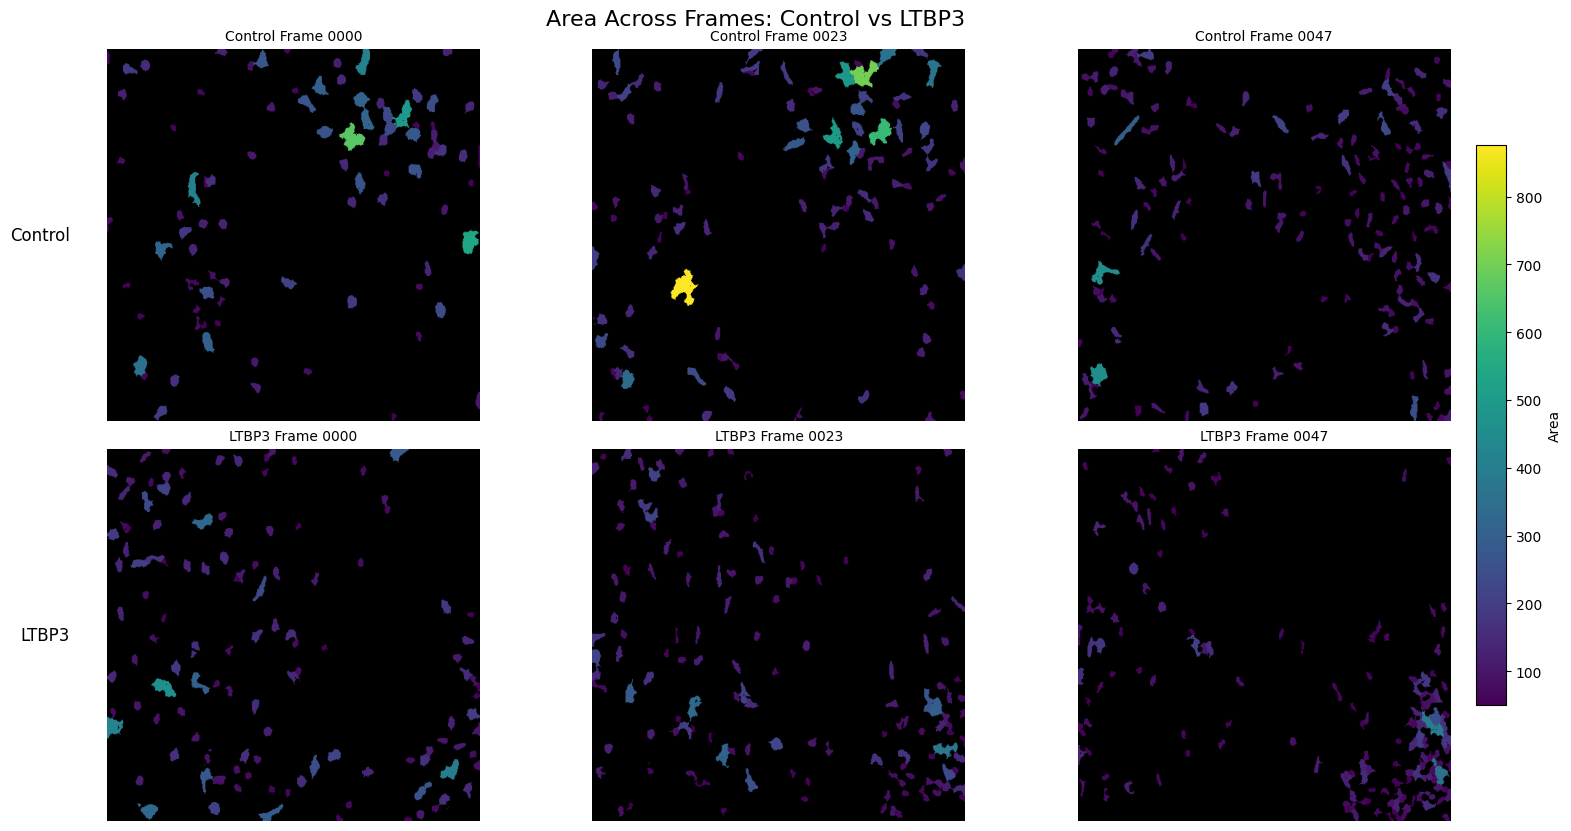

Interpretation for area:
These plots show the spatial distribution of area across cells in first, middle, and last frames. Higher values in LTBP3-deficient cells (warmer colors) suggest hypertrophy (for area, perimeter) or increased boundary complexity (for fractal_dimension). Temporal changes indicate dynamic morphological responses.


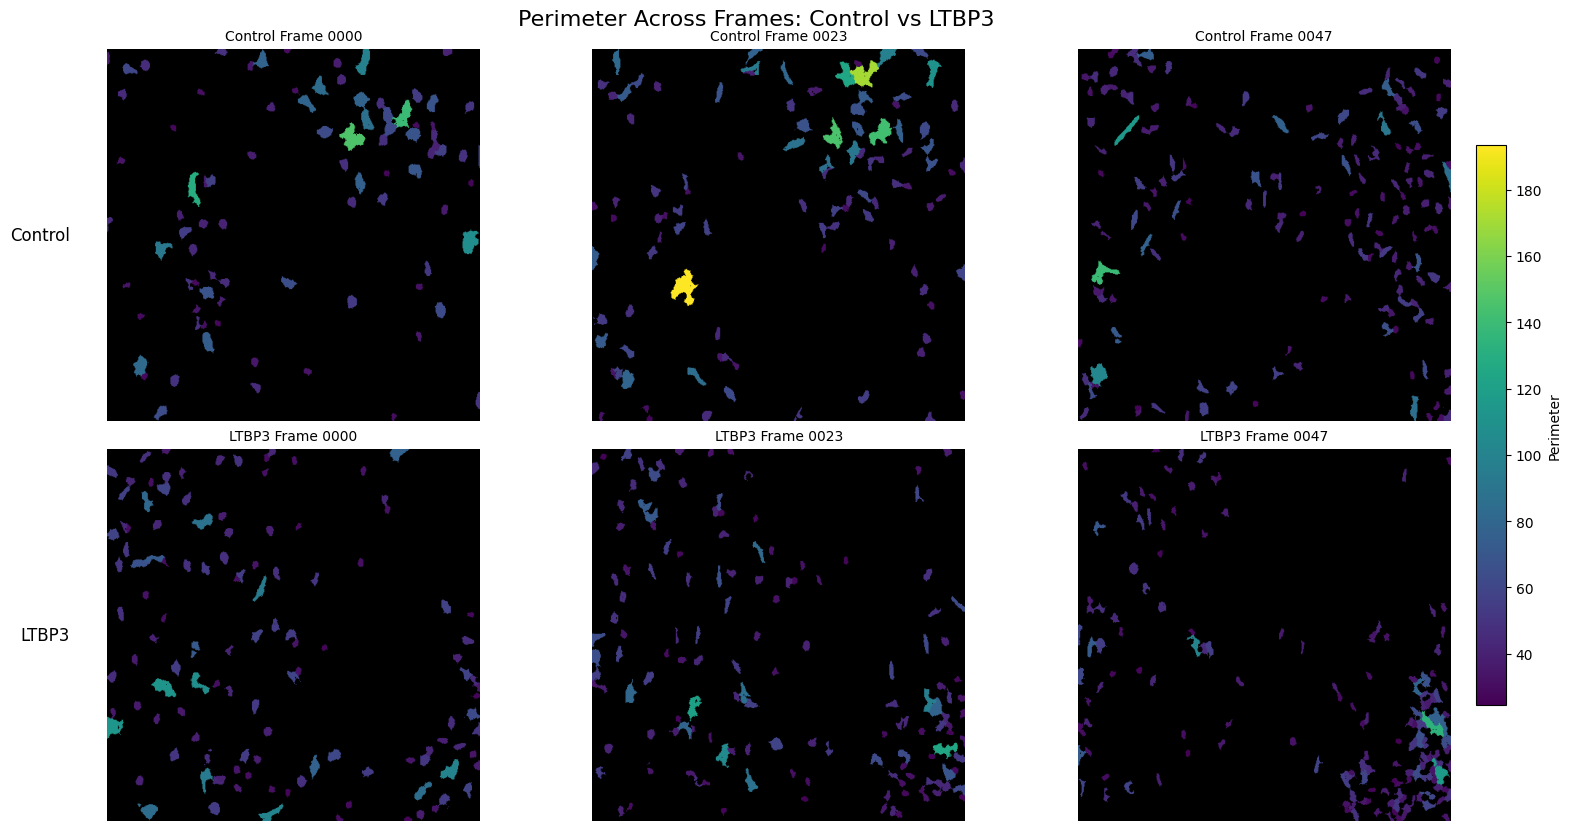

Interpretation for perimeter:
These plots show the spatial distribution of perimeter across cells in first, middle, and last frames. Higher values in LTBP3-deficient cells (warmer colors) suggest hypertrophy (for area, perimeter) or increased boundary complexity (for fractal_dimension). Temporal changes indicate dynamic morphological responses.


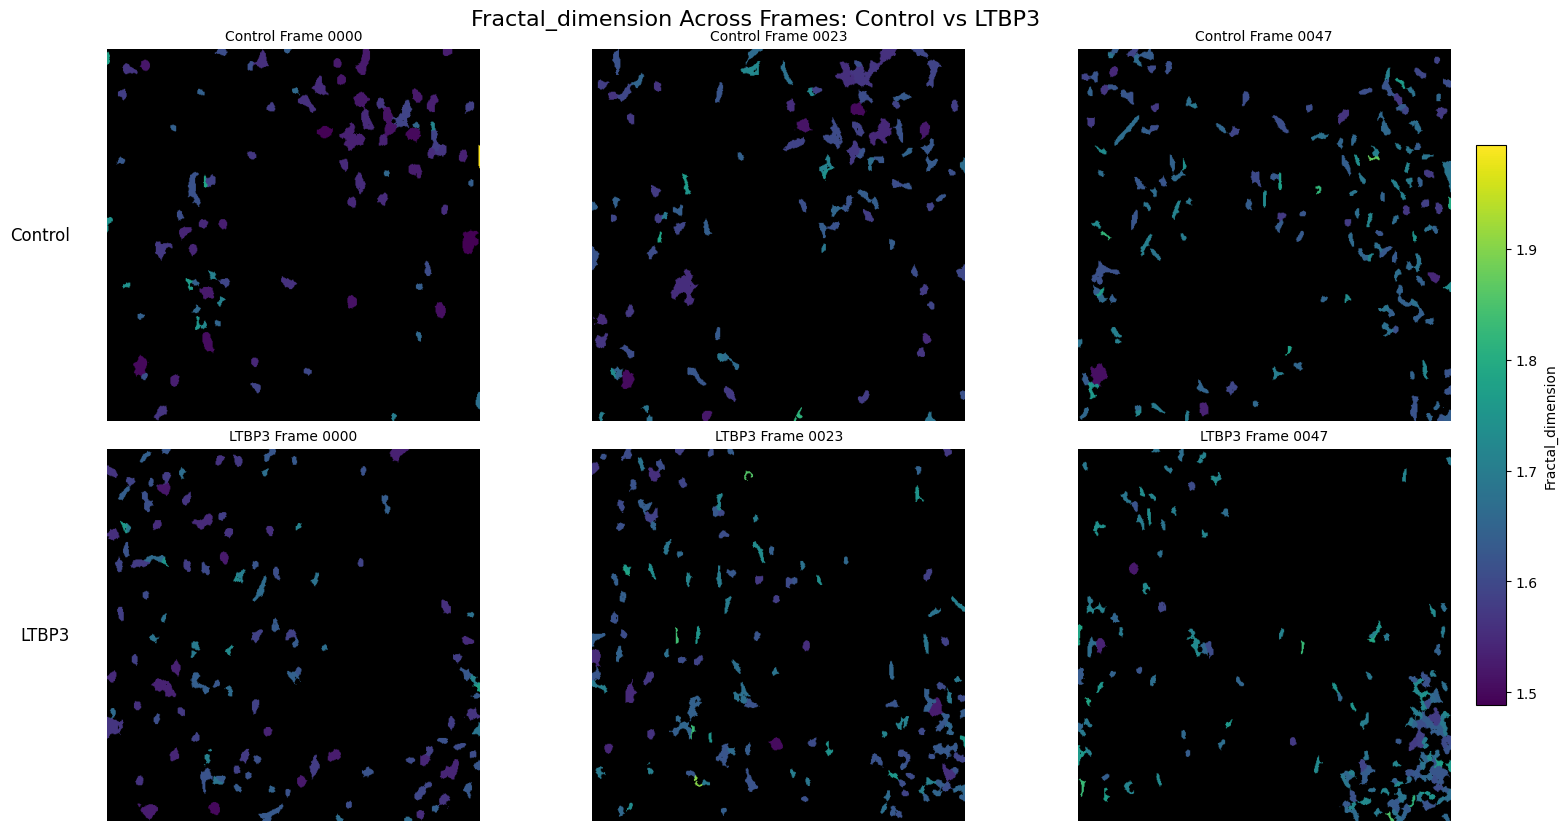

Interpretation for fractal_dimension:
These plots show the spatial distribution of fractal_dimension across cells in first, middle, and last frames. Higher values in LTBP3-deficient cells (warmer colors) suggest hypertrophy (for area, perimeter) or increased boundary complexity (for fractal_dimension). Temporal changes indicate dynamic morphological responses.


In [5]:
# Check for frame_idx
has_frame_idx = 'frame_idx' in df_wildtype.columns and 'frame_idx' in df_mutant.columns

if has_frame_idx:
    def plot_colored_cells(labeled_image, metrics_df, feature, condition, frame_idx, output_path, ax=None, norm=None):
        try:
            regions = regionprops(labeled_image)
            df_frame = metrics_df[metrics_df['frame_idx'] == frame_idx]
            values = df_frame[feature].values
            if len(values) != len(regions):
                logger.warning(f'Mismatch between regions ({len(regions)}) and metrics ({len(values)}) for {feature} in {condition} frame {frame_idx}.')
                return None, None
            cmap = plt.cm.viridis
            colored_image = np.zeros((*labeled_image.shape, 3))
            for region, value in zip(regions, values):
                mask = labeled_image == region.label
                colored_image[mask] = cmap(norm(value))[:3] if norm else cmap(plt.Normalize(np.min(values), np.max(values))(value))[:3]
            if ax is None:
                fig, ax = plt.subplots(figsize=(8, 6))
            im = ax.imshow(colored_image)
            ax.axis('off')
            ax.set_title(f'{condition} Frame {frame_idx:04d}', fontsize=10)
            return im, cmap
        except Exception as e:
            logger.error(f'Error in plot_colored_cells for {condition} frame {frame_idx}, feature {feature}: {e}')
            return None, None

    # Map condition names
    condition_mapping = {
        'Control': {'folder': 'wildtype', 'metrics_condition': 'Control', 'video_name': wildtype_video},
        'LTBP3': {'folder': 'mutant', 'metrics_condition': 'LTBP3', 'video_name': mutant_video}
    }

    # Determine frame indices
    frame_indices = {}
    for condition in ['Control', 'LTBP3']:
        metrics_condition = condition_mapping[condition]['metrics_condition']
        video_name = condition_mapping[condition]['video_name']
        df_cond = df_features[(df_features['condition'] == metrics_condition) & (df_features['video_name'] == video_name)]
        if not df_cond.empty:
            frames = df_cond['frame_idx'].unique()
            frame_indices[condition] = {
                'first': min(frames),
                'middle': int(np.median(frames)),
                'last': max(frames)
            }
        else:
            logger.warning(f'No data for {condition} in {video_name}. Skipping.')
            frame_indices[condition] = {'first': None, 'middle': None, 'last': None}

    # Plot for key features
    for feature in ['area', 'perimeter', 'fractal_dimension']:
        fig, axes = plt.subplots(2, 3, figsize=(15, 8), constrained_layout=True)
        all_values = []
        for condition in ['Control', 'LTBP3']:
            metrics_condition = condition_mapping[condition]['metrics_condition']
            video_name = condition_mapping[condition]['video_name']
            df_cond = df_features[(df_features['condition'] == metrics_condition) & (df_features['video_name'] == video_name)]
            for frame_type in ['first', 'middle', 'last']:
                frame_idx = frame_indices[condition][frame_type]
                if frame_idx is not None:
                    all_values.extend(df_cond[df_cond['frame_idx'] == frame_idx][feature].values)
        global_norm = plt.Normalize(np.min(all_values), np.max(all_values)) if all_values else None

        for row_idx, condition in enumerate(['Control', 'LTBP3']):
            metrics_condition = condition_mapping[condition]['metrics_condition']
            video_name = condition_mapping[condition]['video_name']
            df_cond = df_features[(df_features['condition'] == metrics_condition) & (df_features['video_name'] == video_name)]
            folder_name = condition_mapping[condition]['folder']
            for col_idx, frame_type in enumerate(['first', 'middle', 'last']):
                frame_idx = frame_indices[condition][frame_type]
                ax = axes[row_idx, col_idx]
                if frame_idx is None:
                    ax.text(0.5, 0.5, 'No Data', ha='center', va='center', fontsize=10)
                    ax.axis('off')
                    continue
                labeled_path = data_dir / folder_name / video_name / f'frame_{frame_idx:04d}' / f'{folder_name}_{video_name}_frame_{frame_idx:04d}_labeled.tif'
                if labeled_path.exists():
                    labeled = imageio.imread(labeled_path)
                    im, cmap = plot_colored_cells(labeled, df_cond, feature, condition, frame_idx, 
                                                  morph_dir / f'{condition.lower()}_frame_{frame_idx:04d}_colored_{feature}.png', 
                                                  ax=ax, norm=global_norm)
                    if not im:
                        ax.text(0.5, 0.5, f'No Image\nFrame {frame_idx:04d}', ha='center', va='center', fontsize=10)
                        ax.axis('off')
                else:
                    ax.text(0.5, 0.5, f'No Image\nFrame {frame_idx:04d}', ha='center', va='center', fontsize=10)
                    ax.axis('off')

        if global_norm:
            cbar_ax = fig.add_axes([0.98, 0.15, 0.02, 0.7])
            plt.colorbar(plt.cm.ScalarMappable(norm=global_norm, cmap=plt.cm.viridis), cax=cbar_ax, label=f'{feature.capitalize()}')

        for i, condition in enumerate(['Control', 'LTBP3']):
            axes[i, 0].text(-0.1, 0.5, condition, va='center', ha='right', fontsize=12, transform=axes[i, 0].transAxes)

        fig.suptitle(f'{feature.capitalize()} Across Frames: Control vs LTBP3', fontsize=16, y=1.02)
        plt.savefig(morph_dir / f'feature_plot_{feature}.png', dpi=300, bbox_inches='tight')
        plt.show()
        plt.close(fig)

        print(f'Interpretation for {feature}:')
        print(f'These plots show the spatial distribution of {feature} across cells in first, middle, and last frames. Higher values in LTBP3-deficient cells (warmer colors) suggest hypertrophy (for area, perimeter) or increased boundary complexity (for fractal_dimension). Temporal changes indicate dynamic morphological responses.')
else:
    print('Skipping visualization due to missing frame_idx.')

## 5. Pairplot Analysis for First Frame

**Purpose**: Explore correlations between size and shape features in the first frame to identify relationships and differences between conditions.

**Method**:
- Generate pairplots for size and shape features in the first frame (frame_idx=0) for each condition.
- Use histograms on diagonals for distribution insights.

**Why Important**: Pairplots reveal feature interdependencies (e.g., area vs. perimeter) and differences in distributions, testing the hypothesis about hypertrophy and shape changes.

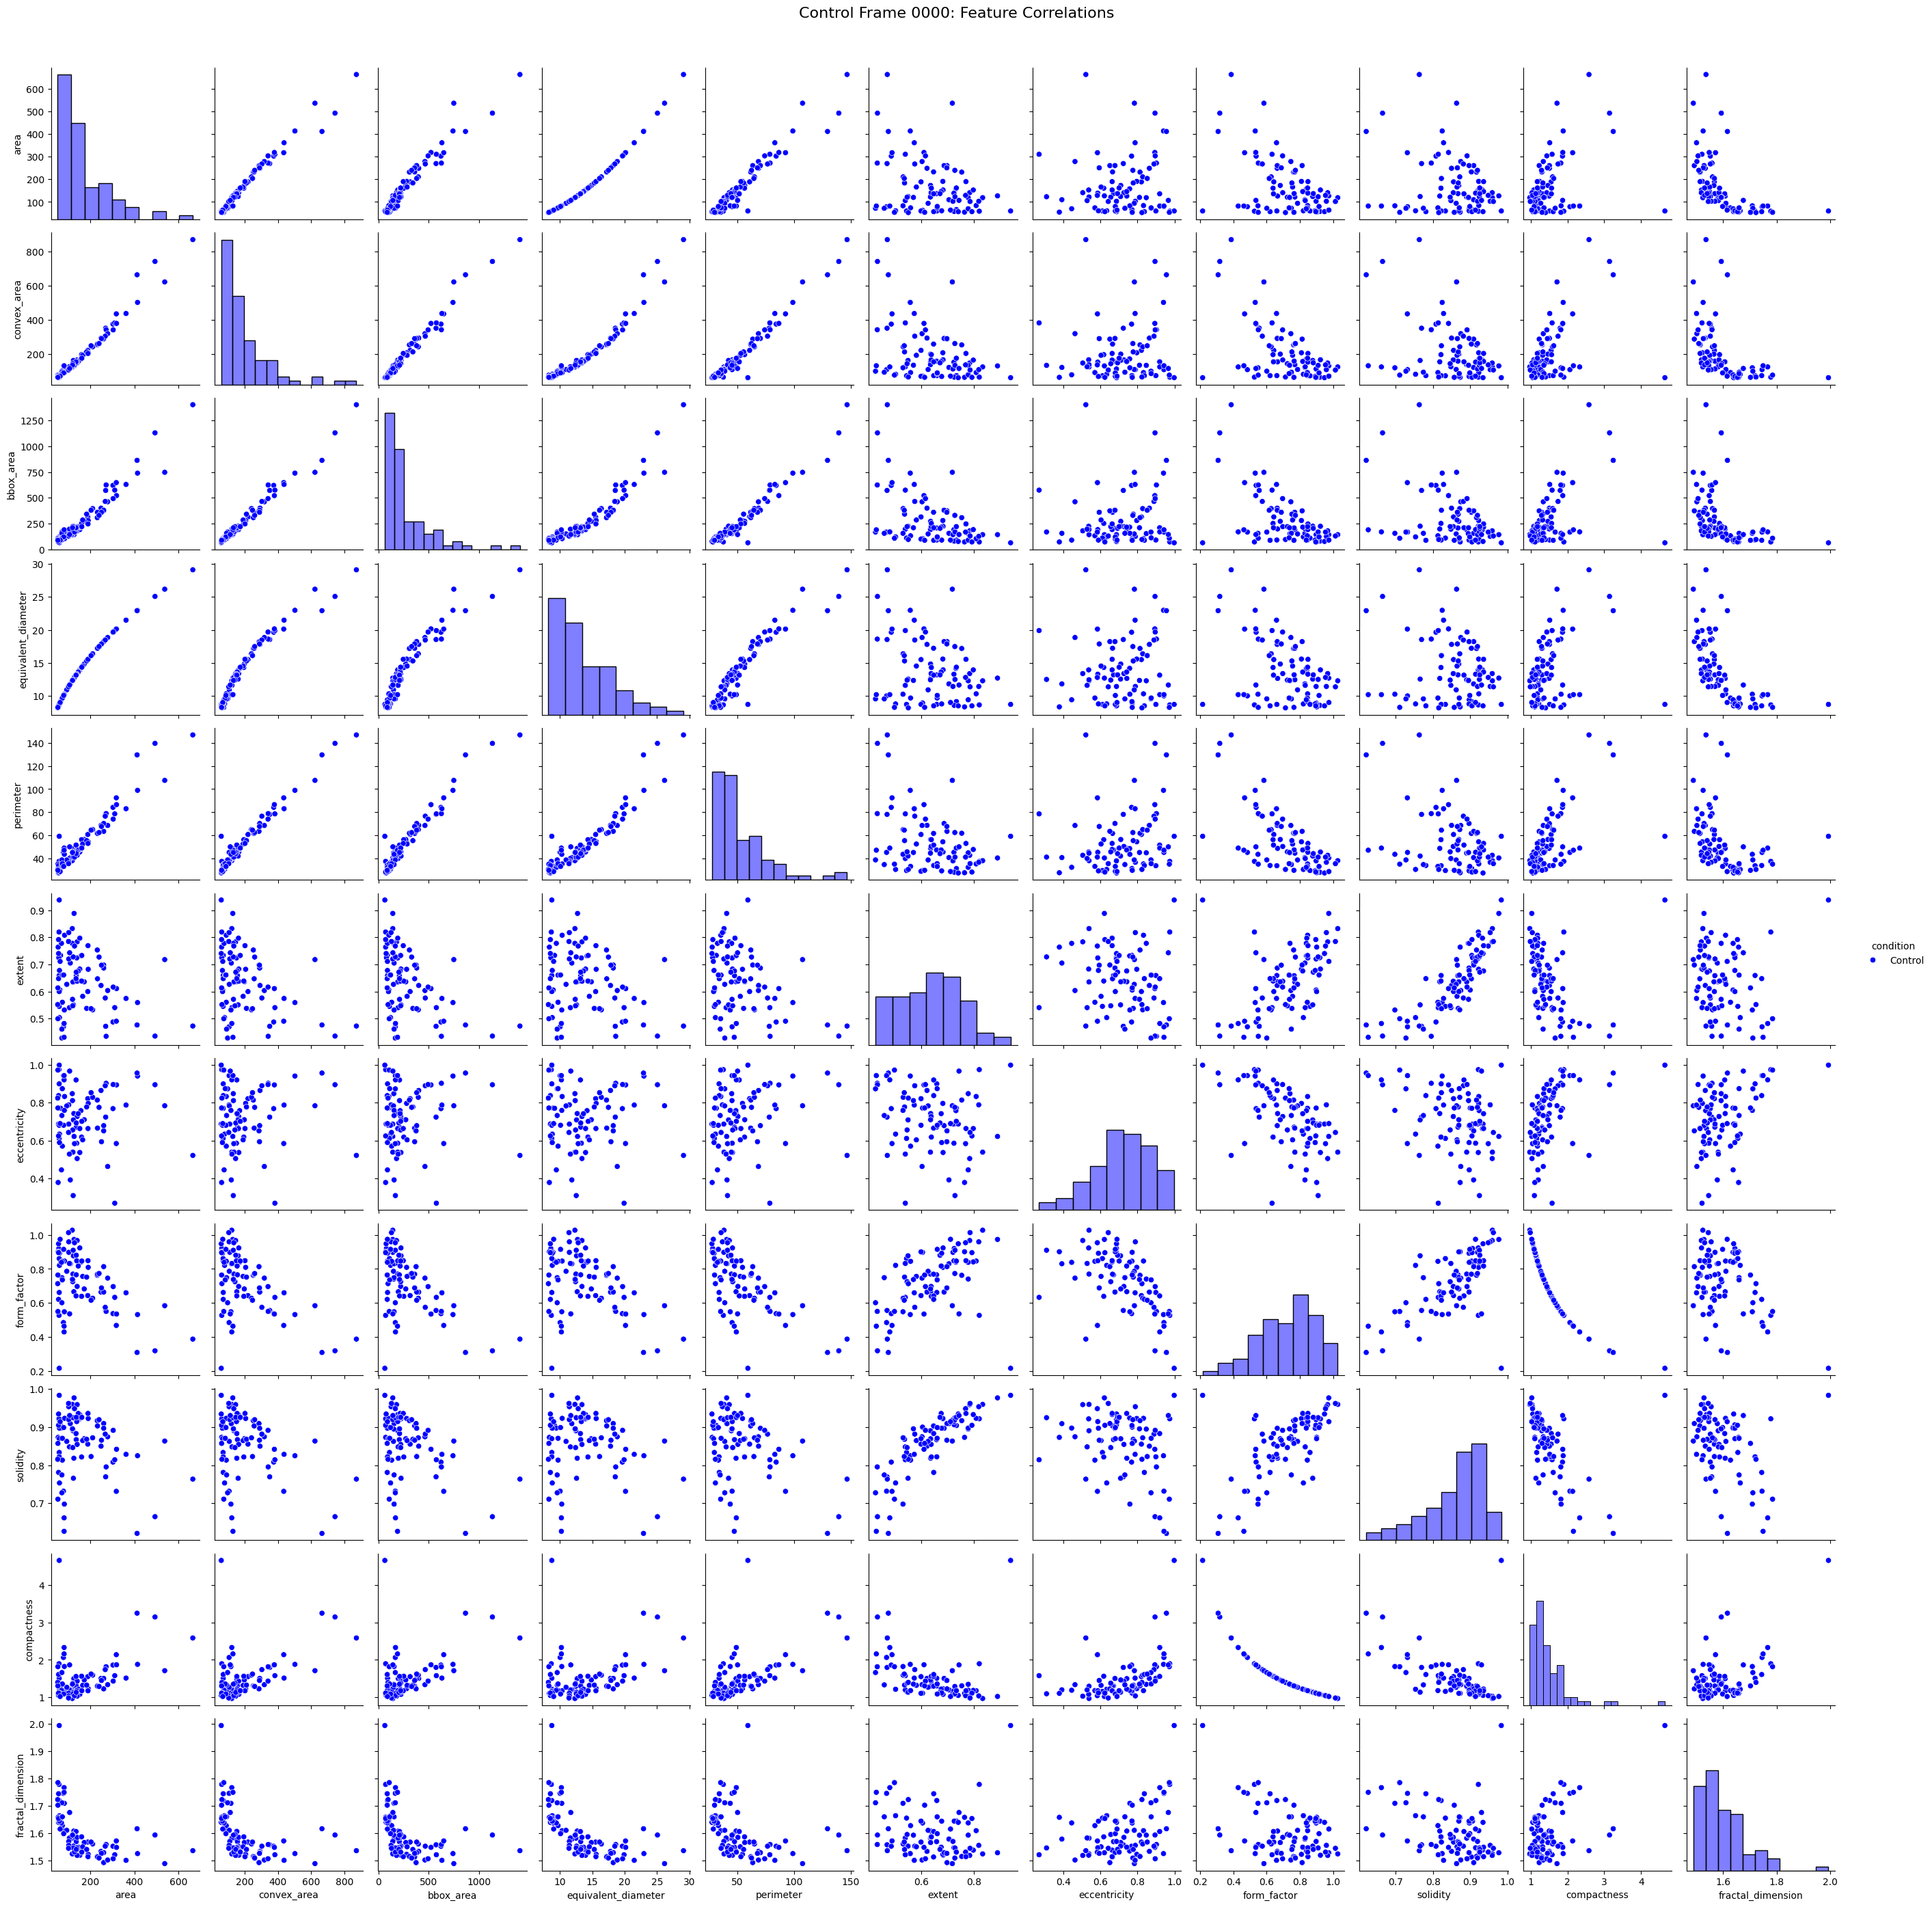

Interpretation for Control pairplot:
This pairplot shows pairwise correlations between size and shape features. Strong positive correlations (e.g., area vs. convex_area) indicate redundancy, while shifts in LTBP3 distributions suggest hypertrophy or shape changes. Histograms on the diagonal highlight distribution differences.


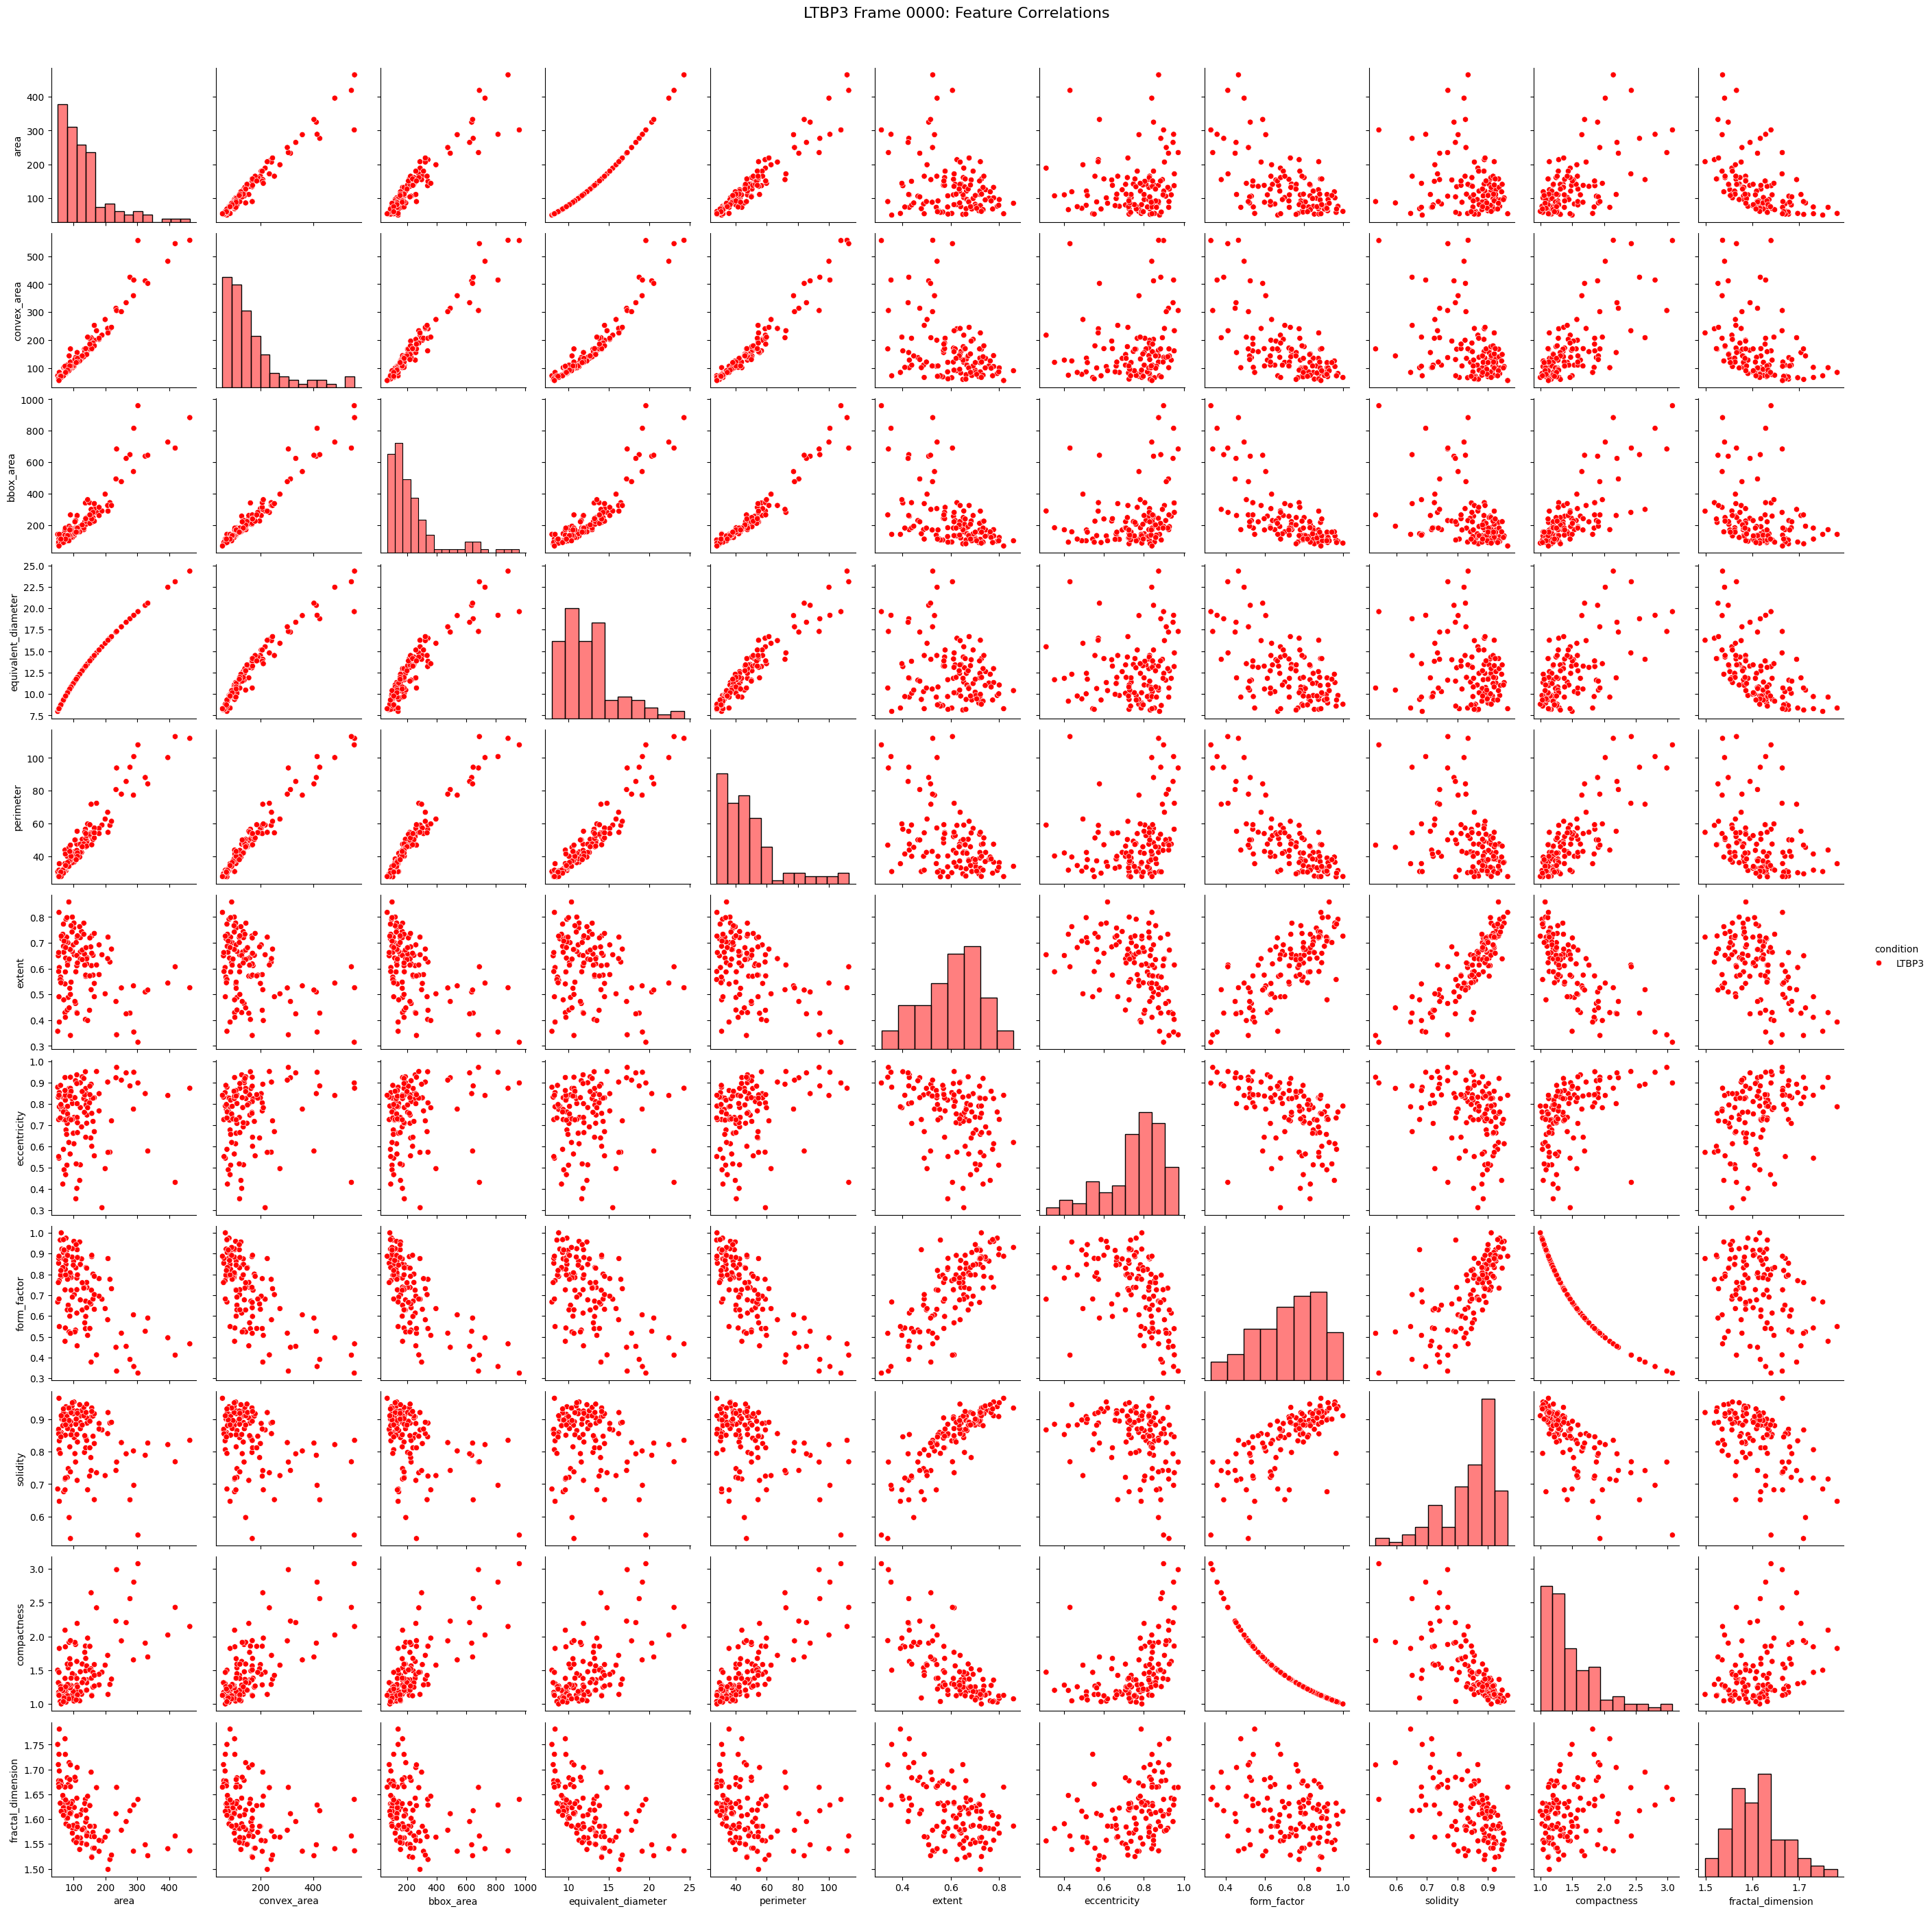

Interpretation for LTBP3 pairplot:
This pairplot shows pairwise correlations between size and shape features. Strong positive correlations (e.g., area vs. convex_area) indicate redundancy, while shifts in LTBP3 distributions suggest hypertrophy or shape changes. Histograms on the diagonal highlight distribution differences.


In [6]:
def plot_pairplot(df, condition, frame_idx, output_path):
    try:
        df_frame = df[(df['condition'] == condition) & (df['frame_idx'] == frame_idx)]
        if df_frame.empty:
            logger.warning(f'No data for {condition} frame {frame_idx}. Skipping pairplot.')
            return
        g = sns.pairplot(df_frame, vars=size_features + shape_features, hue='condition', palette={'Control': 'blue', 'LTBP3': 'red'}, diag_kind='hist')
        g.fig.suptitle(f'{condition} Frame {frame_idx:04d}: Feature Correlations', y=1.02, fontsize=16)
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close(g.fig)
        print(f'Interpretation for {condition} pairplot:')
        print('This pairplot shows pairwise correlations between size and shape features. Strong positive correlations (e.g., area vs. convex_area) indicate redundancy, while shifts in LTBP3 distributions suggest hypertrophy or shape changes. Histograms on the diagonal highlight distribution differences.')
    except Exception as e:
        logger.error(f'Error generating pairplot for {condition} frame {frame_idx}: {e}')

# Generate pairplots for first frame
for condition in ['Control', 'LTBP3']:
    frame_idx = df_features[df_features['condition'] == condition]['frame_idx'].min()
    plot_pairplot(df_features, condition, frame_idx, morph_dir / f'{condition.lower()}_frame_{frame_idx:04d}_pairplot.png')

## 6. Time Series Analysis

**Purpose**: Analyze temporal trends in cell count, area, and perimeter to assess stability and variability.

**Method**:
- Plot number of cells and average area/perimeter per frame, with standard deviation bands.
- Use line plots with markers for clarity.

**Why Important**: Temporal trends reveal whether LTBP3 deficiency leads to dynamic changes in cell number or morphology, critical for understanding disease progression.

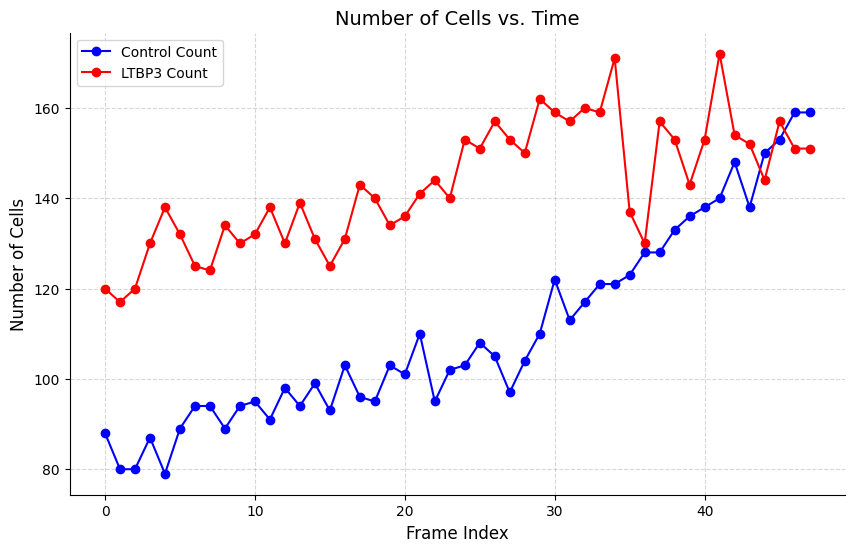

Interpretation for Number of Cells:
This plot shows temporal trends in Number of Cells. Higher means or variability in LTBP3-deficient cells suggest dynamic morphological changes, potentially due to altered TGF-β signaling. Stable cell counts indicate consistent imaging conditions.


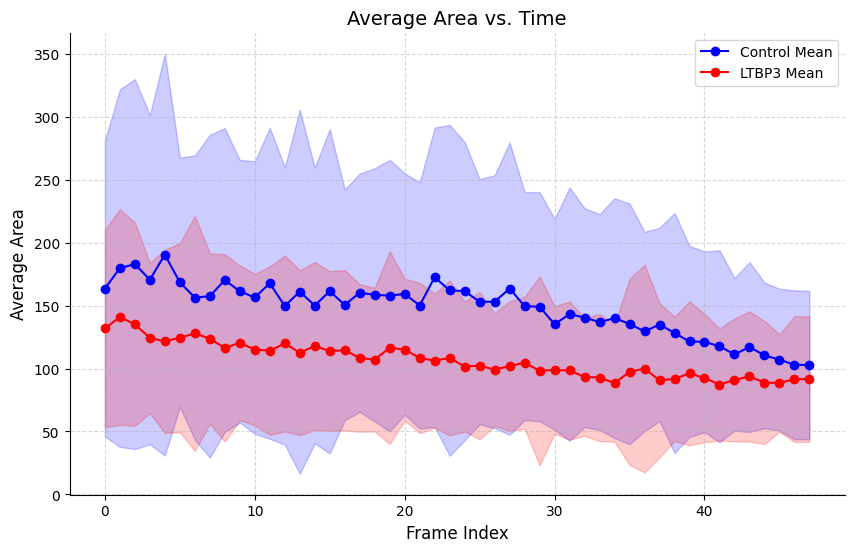

Interpretation for Average Area:
This plot shows temporal trends in Average Area. Higher means or variability in LTBP3-deficient cells suggest dynamic morphological changes, potentially due to altered TGF-β signaling. Stable cell counts indicate consistent imaging conditions.


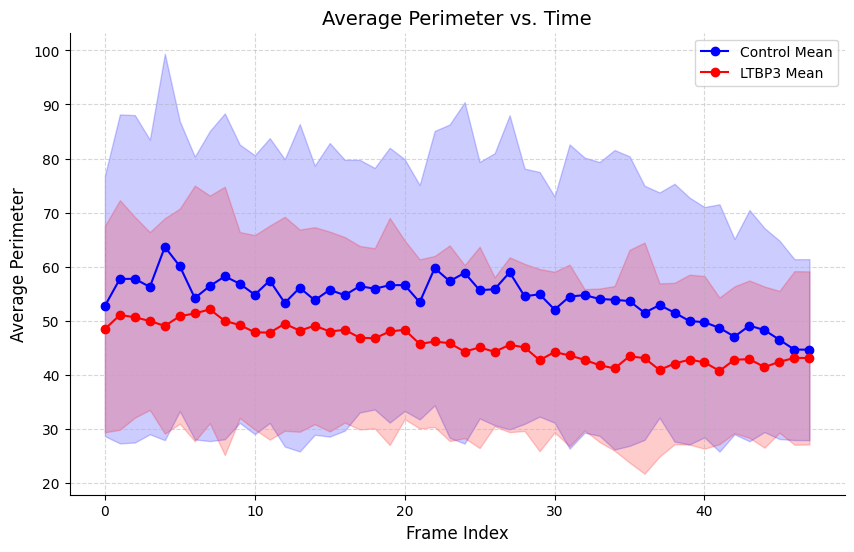

Interpretation for Average Perimeter:
This plot shows temporal trends in Average Perimeter. Higher means or variability in LTBP3-deficient cells suggest dynamic morphological changes, potentially due to altered TGF-β signaling. Stable cell counts indicate consistent imaging conditions.


In [7]:
def plot_timeseries(df, metric, ylabel, output_path):
    try:
        plt.figure(figsize=(10, 6))
        for condition in ['Control', 'LTBP3']:
            if metric == 'cell_id':
                df_cond = df[df['condition'] == condition].groupby('frame_idx').agg({metric: 'nunique'}).reset_index()
                df_cond.columns = ['frame_idx', 'count']
                plt.plot(df_cond['frame_idx'], df_cond['count'], label=f'{condition} Count', marker='o', color='blue' if condition == 'Control' else 'red')
            else:
                df_cond = df[df['condition'] == condition].groupby('frame_idx').agg({metric: ['mean', 'std']}).reset_index()
                df_cond.columns = ['frame_idx', 'mean', 'std']
                plt.plot(df_cond['frame_idx'], df_cond['mean'], label=f'{condition} Mean', marker='o', color='blue' if condition == 'Control' else 'red')
                plt.fill_between(df_cond['frame_idx'], df_cond['mean'] - df_cond['std'], df_cond['mean'] + df_cond['std'], 
                                 alpha=0.2, color='blue' if condition == 'Control' else 'red')
        plt.title(f'{ylabel} vs. Time', fontsize=14)
        plt.xlabel('Frame Index', fontsize=12)
        plt.ylabel(ylabel, fontsize=12)
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)
        sns.despine()
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()
        print(f'Interpretation for {ylabel}:')
        print(f'This plot shows temporal trends in {ylabel}. Higher means or variability in LTBP3-deficient cells suggest dynamic morphological changes, potentially due to altered TGF-β signaling. Stable cell counts indicate consistent imaging conditions.')
    except Exception as e:
        logger.error(f'Error in timeseries plot for {metric}: {e}')

if has_frame_idx:
    plot_timeseries(df_features, 'cell_id', 'Number of Cells', morph_dir / 'timeseries_num_cells.png')
    plot_timeseries(df_features, 'area', 'Average Area', morph_dir / 'timeseries_avg_area.png')
    plot_timeseries(df_features, 'perimeter', 'Average Perimeter', morph_dir / 'timeseries_avg_perimeter.png')
else:
    print('Skipping time series analysis due to missing frame_idx.')

## 7. Correlation Analysis

**Purpose**: Identify feature interdependencies to assess redundancy and biological relationships.

**Method**:
- Compute Spearman correlation matrix (non-parametric, suitable for non-normal data).
- Visualize with a heatmap and a network graph (|r|>0.7) for strong correlations.

**Why Important**: Reveals which features are redundant (e.g., area vs. convex_area) or biologically linked (e.g., dendrite_count vs. fractal_dimension), guiding feature selection for modeling.

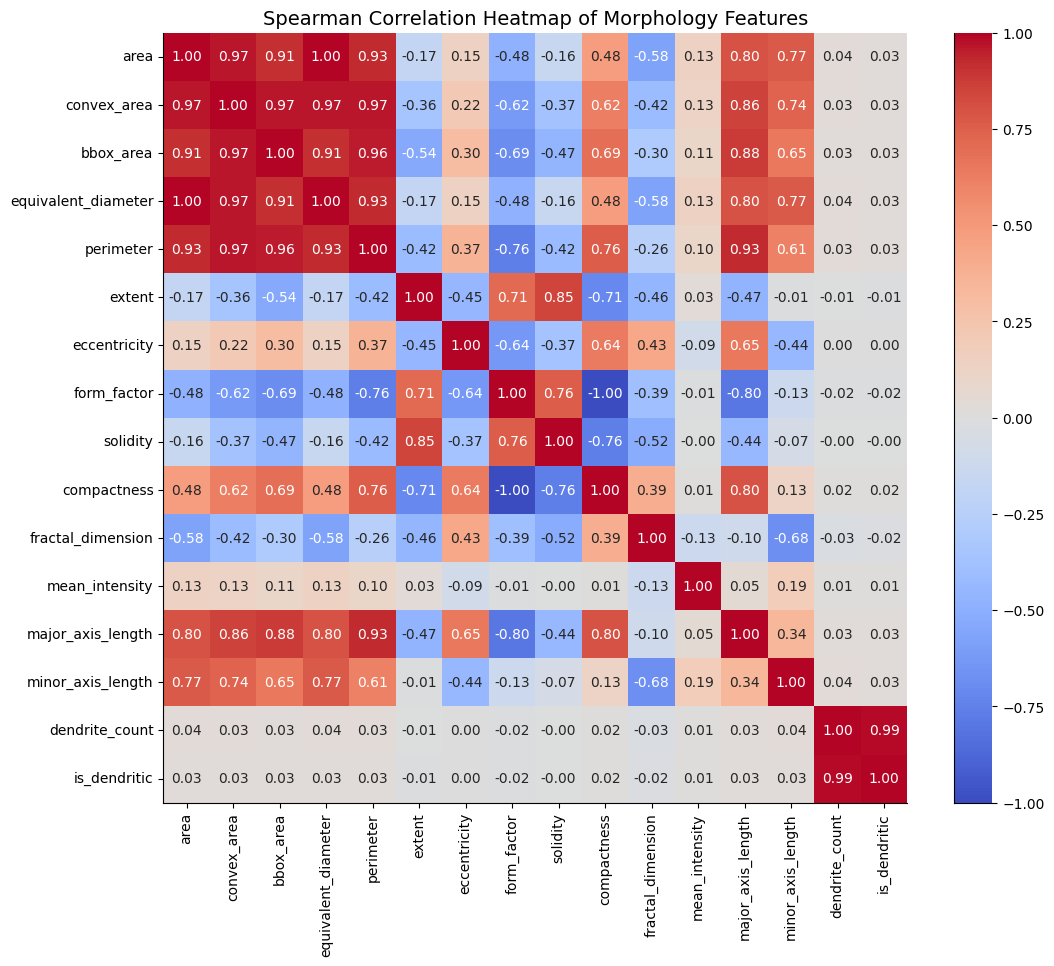

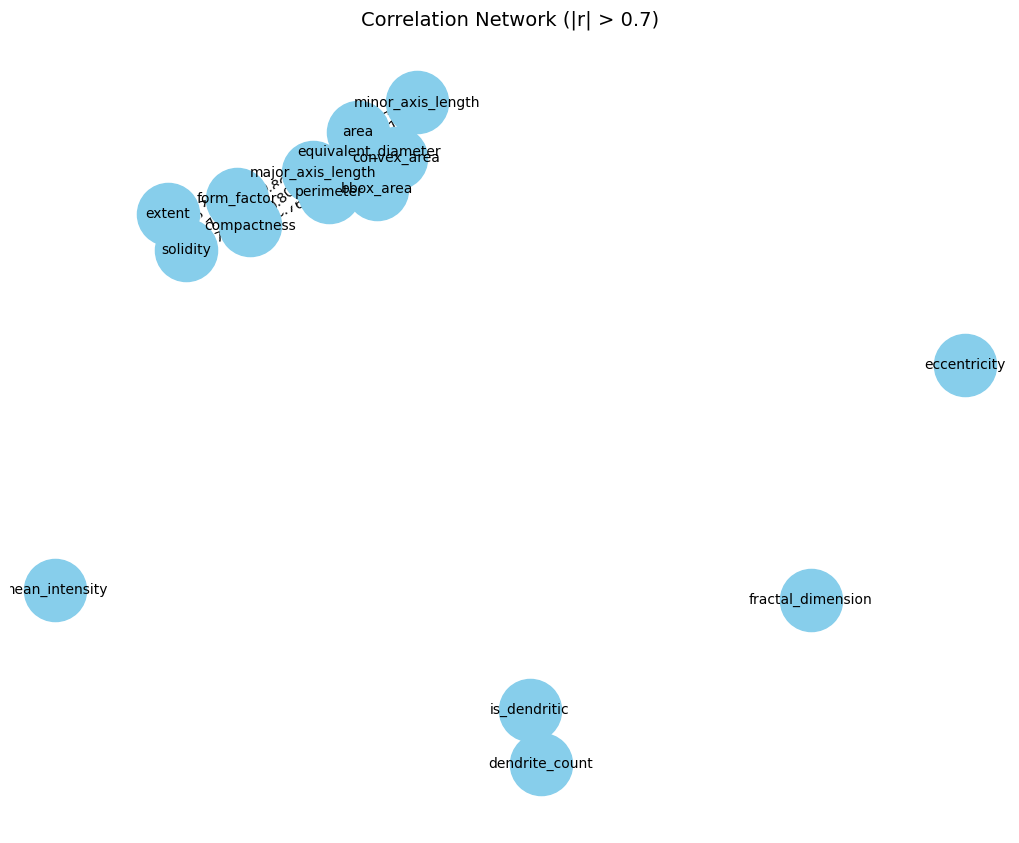

Interpretation:
The heatmap shows Spearman correlations between features. Strong correlations (e.g., area vs. convex_area) indicate redundant metrics, while correlations between dendrite_count and fractal_dimension suggest linked branching mechanisms. The network graph highlights strong relationships (|r|>0.7), useful for feature selection in modeling.


In [9]:
# Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df_features[features].corr(method='spearman'), annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title('Spearman Correlation Heatmap of Morphology Features', fontsize=14)
sns.despine()
plt.savefig(morph_dir / 'correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Correlation network
corr_matrix = df_features[features].corr(method='spearman').abs()
G = nx.Graph()
for f1 in features:
    G.add_node(f1)
for i, f1 in enumerate(features):
    for f2 in features[i+1:]:
        if corr_matrix.loc[f1, f2] > 0.7:
            G.add_edge(f1, f2, weight=corr_matrix.loc[f1, f2])

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, font_size=10)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels={k: f'{v:.2f}' for k, v in edge_labels.items()})
plt.title('Correlation Network (|r| > 0.7)', fontsize=14)
plt.savefig(morph_dir / 'correlation_network.png', dpi=300, bbox_inches='tight')
plt.show()

print('Interpretation:')
print('The heatmap shows Spearman correlations between features. Strong correlations (e.g., area vs. convex_area) indicate redundant metrics, while correlations between dendrite_count and fractal_dimension suggest linked branching mechanisms. The network graph highlights strong relationships (|r|>0.7), useful for feature selection in modeling.')

## 8. PCA and Clustering

**Purpose**: Reduce dimensionality to visualize group separation and identify morphological clusters.

**Method**:
- Apply PCA to standardized features, selecting components explaining ≥90% variance.
- Plot PCA scatter with confidence ellipses and loadings to identify key features.
- Perform K-means clustering, selecting optimal clusters via silhouette scores.
- Visualize clusters in PCA space.

**Why Important**: PCA reveals whether Control and LTBP3-deficient cells form distinct morphological groups. Clustering identifies subgroups, potentially reflecting heterogeneous responses to LTBP3 deficiency.

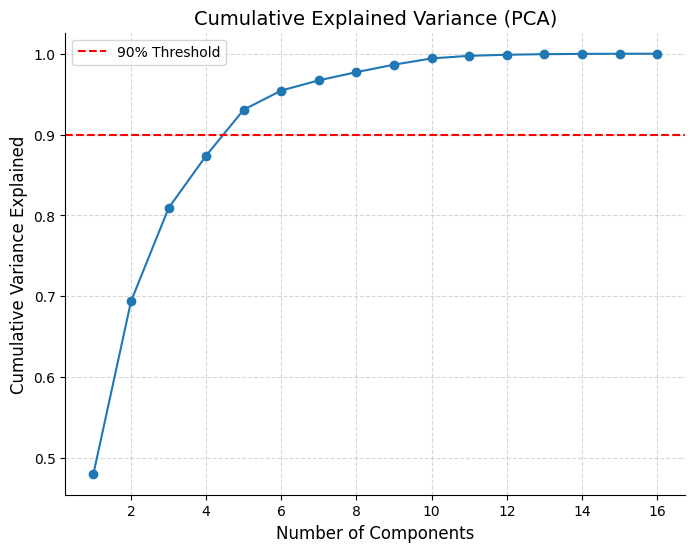

First 5 PCs explain 93.08% of variance.
Error in PCA and clustering analysis: name 'chi2' is not defined


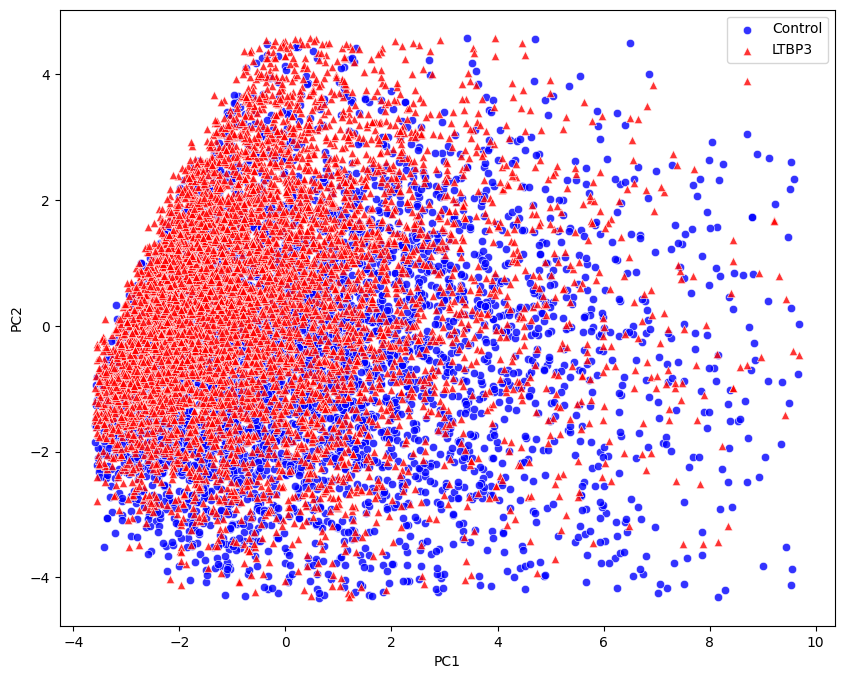

In [10]:
try:
    X = df_features[features]
    y = df_features['condition']
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # PCA
    pca_full = PCA()
    pca_full.fit(X_scaled)
    cum_var = np.cumsum(pca_full.explained_variance_ratio_)
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(cum_var) + 1), cum_var, marker='o')
    plt.axhline(0.9, color='r', linestyle='--', label='90% Threshold')
    plt.title('Cumulative Explained Variance (PCA)', fontsize=14)
    plt.xlabel('Number of Components', fontsize=12)
    plt.ylabel('Cumulative Variance Explained', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    sns.despine()
    plt.savefig(morph_dir / 'pca_knee_plot.png', dpi=300, bbox_inches='tight')
    plt.show()

    n_comp = np.where(cum_var >= 0.9)[0][0] + 1
    pca = PCA(n_components=n_comp)
    X_pca = pca.fit_transform(X_scaled)
    print(f'First {n_comp} PCs explain {np.sum(pca.explained_variance_ratio_):.2%} of variance.')

    df_pca = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(n_comp)])
    df_pca['condition'] = y.values
    q_low_pc1, q_high_pc1 = df_pca['PC1'].quantile([0.01, 0.99])
    q_low_pc2, q_high_pc2 = df_pca['PC2'].quantile([0.01, 0.99])
    df_pca_filtered = df_pca[(df_pca['PC1'] >= q_low_pc1) & (df_pca['PC1'] <= q_high_pc1) &
                            (df_pca['PC2'] >= q_low_pc2) & (df_pca['PC2'] <= q_high_pc2)]

    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=df_pca_filtered[df_pca_filtered['condition'] == 'Control'], x='PC1', y='PC2', color='blue', marker='o', label='Control', alpha=0.8)
    sns.scatterplot(data=df_pca_filtered[df_pca_filtered['condition'] == 'LTBP3'], x='PC1', y='PC2', color='red', marker='^', label='LTBP3', alpha=0.8)

    def add_group_ellipse(df, color, label, x_col='PC1', y_col='PC2', level=0.95):
        if len(df) <= 2:
            return
        data = df[[x_col, y_col]].values
        mean = np.mean(data, axis=0)
        cov = np.cov(data.T)
        eigvals, eigvecs = np.linalg.eigh(cov)
        idx = np.argsort(eigvals)[::-1]
        eigvals = eigvals[idx]
        eigvecs = eigvecs[:, idx]
        angle = np.degrees(np.arctan2(eigvecs[1,0], eigvecs[0,0]))
        scale = np.sqrt(chi2.ppf(level, df=2))
        width = 2 * np.sqrt(eigvals[0]) * scale
        height = 2 * np.sqrt(eigvals[1]) * scale
        ell = Ellipse(xy=mean, width=width, height=height, angle=angle, facecolor=color, edgecolor=color, alpha=0.2, linewidth=1)
        plt.gca().add_artist(ell)
        plt.annotate(label, (mean[0], mean[1]), color='black', ha='center', va='center', fontsize=10, zorder=11)

    add_group_ellipse(df_pca_filtered[df_pca_filtered['condition'] == 'Control'], 'blue', 'Control')
    add_group_ellipse(df_pca_filtered[df_pca_filtered['condition'] == 'LTBP3'], 'red', 'LTBP3')
    buffer_pc1 = 0.1 * (q_high_pc1 - q_low_pc1)
    buffer_pc2 = 0.1 * (q_high_pc2 - q_low_pc2)
    plt.xlim(q_low_pc1 - buffer_pc1, q_high_pc1 + buffer_pc1)
    plt.ylim(q_low_pc2 - buffer_pc2, q_high_pc2 + buffer_pc2)
    plt.title('Principal Component Analysis of Osteocyte Morphology', fontsize=14)
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} Variance Explained)', fontsize=12)
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} Variance Explained)', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    sns.despine()
    plt.savefig(morph_dir / 'pca_plot.png', dpi=300, bbox_inches='tight')
    plt.show()

    # PCA loadings
    loadings = pd.DataFrame(pca.components_.T * np.sqrt(pca.explained_variance_), columns=[f'PC{i+1}' for i in range(n_comp)], index=features)
    plt.figure(figsize=(10, 8))
    sns.heatmap(loadings, annot=True, cmap='RdBu', vmin=-1, vmax=1)
    plt.title('PCA Loadings Heatmap', fontsize=14)
    sns.despine()
    plt.savefig(morph_dir / 'pca_loadings.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Clustering
    sil_scores = []
    cluster_range = range(2, 11)
    for n in cluster_range:
        kmeans = KMeans(n_clusters=n, random_state=42)
        labels = kmeans.fit_predict(X_pca)
        sil_scores.append(silhouette_score(X_pca, labels))

    optimal_n = cluster_range[np.argmax(sil_scores)]
    optimal_sil_score = max(sil_scores)
    print(f'Optimal number of clusters: {optimal_n} (Silhouette Score: {optimal_sil_score:.3f})')

    kmeans = KMeans(n_clusters=optimal_n, random_state=42)
    df_pca['cluster'] = kmeans.fit_predict(X_pca)
    df_pca_filtered = df_pca_filtered.merge(df_pca[['cluster']], left_index=True, right_index=True, how='left')

    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=df_pca_filtered, x='PC1', y='PC2', hue='cluster', palette='Set1', alpha=0.8)
    plt.title(f'K-Means Clusters on PCA Space (n_clusters={optimal_n}, Silhouette Score: {optimal_sil_score:.3f})', fontsize=14)
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} Variance Explained)', fontsize=12)
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} Variance Explained)', fontsize=12)
    plt.xlim(q_low_pc1 - buffer_pc1, q_high_pc1 + buffer_pc1)
    plt.ylim(q_low_pc2 - buffer_pc2, q_high_pc2 + buffer_pc2)
    plt.grid(True, linestyle='--', alpha=0.5)
    sns.despine()
    plt.savefig(morph_dir / 'kmeans_plot.png', dpi=300, bbox_inches='tight')
    plt.show()

    print('Interpretation:')
    print('PCA scatter plots show separation between Control and LTBP3-deficient cells, with ellipses indicating group spread. Loadings highlight features (e.g., area, fractal_dimension) driving differences. Clustering identifies morphological subgroups, with high silhouette scores indicating distinct clusters. LTBP3-deficient cells may form separate clusters due to hypertrophy and branching.')
except Exception as e:
    print(f'Error in PCA and clustering analysis: {e}')

## 9. Feature Distribution Analysis

**Purpose**: Compare feature distributions between conditions to quantify differences and visualize variability.

**Method**:
- Create violin-box plots for each feature, showing distributions and outliers.
- Annotate with adjusted p-values and Cohen’s d for significance.

**Why Important**: Visualizes the magnitude and significance of morphological differences, critical for validating hypotheses in the thesis.

Error in feature distribution analysis: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.


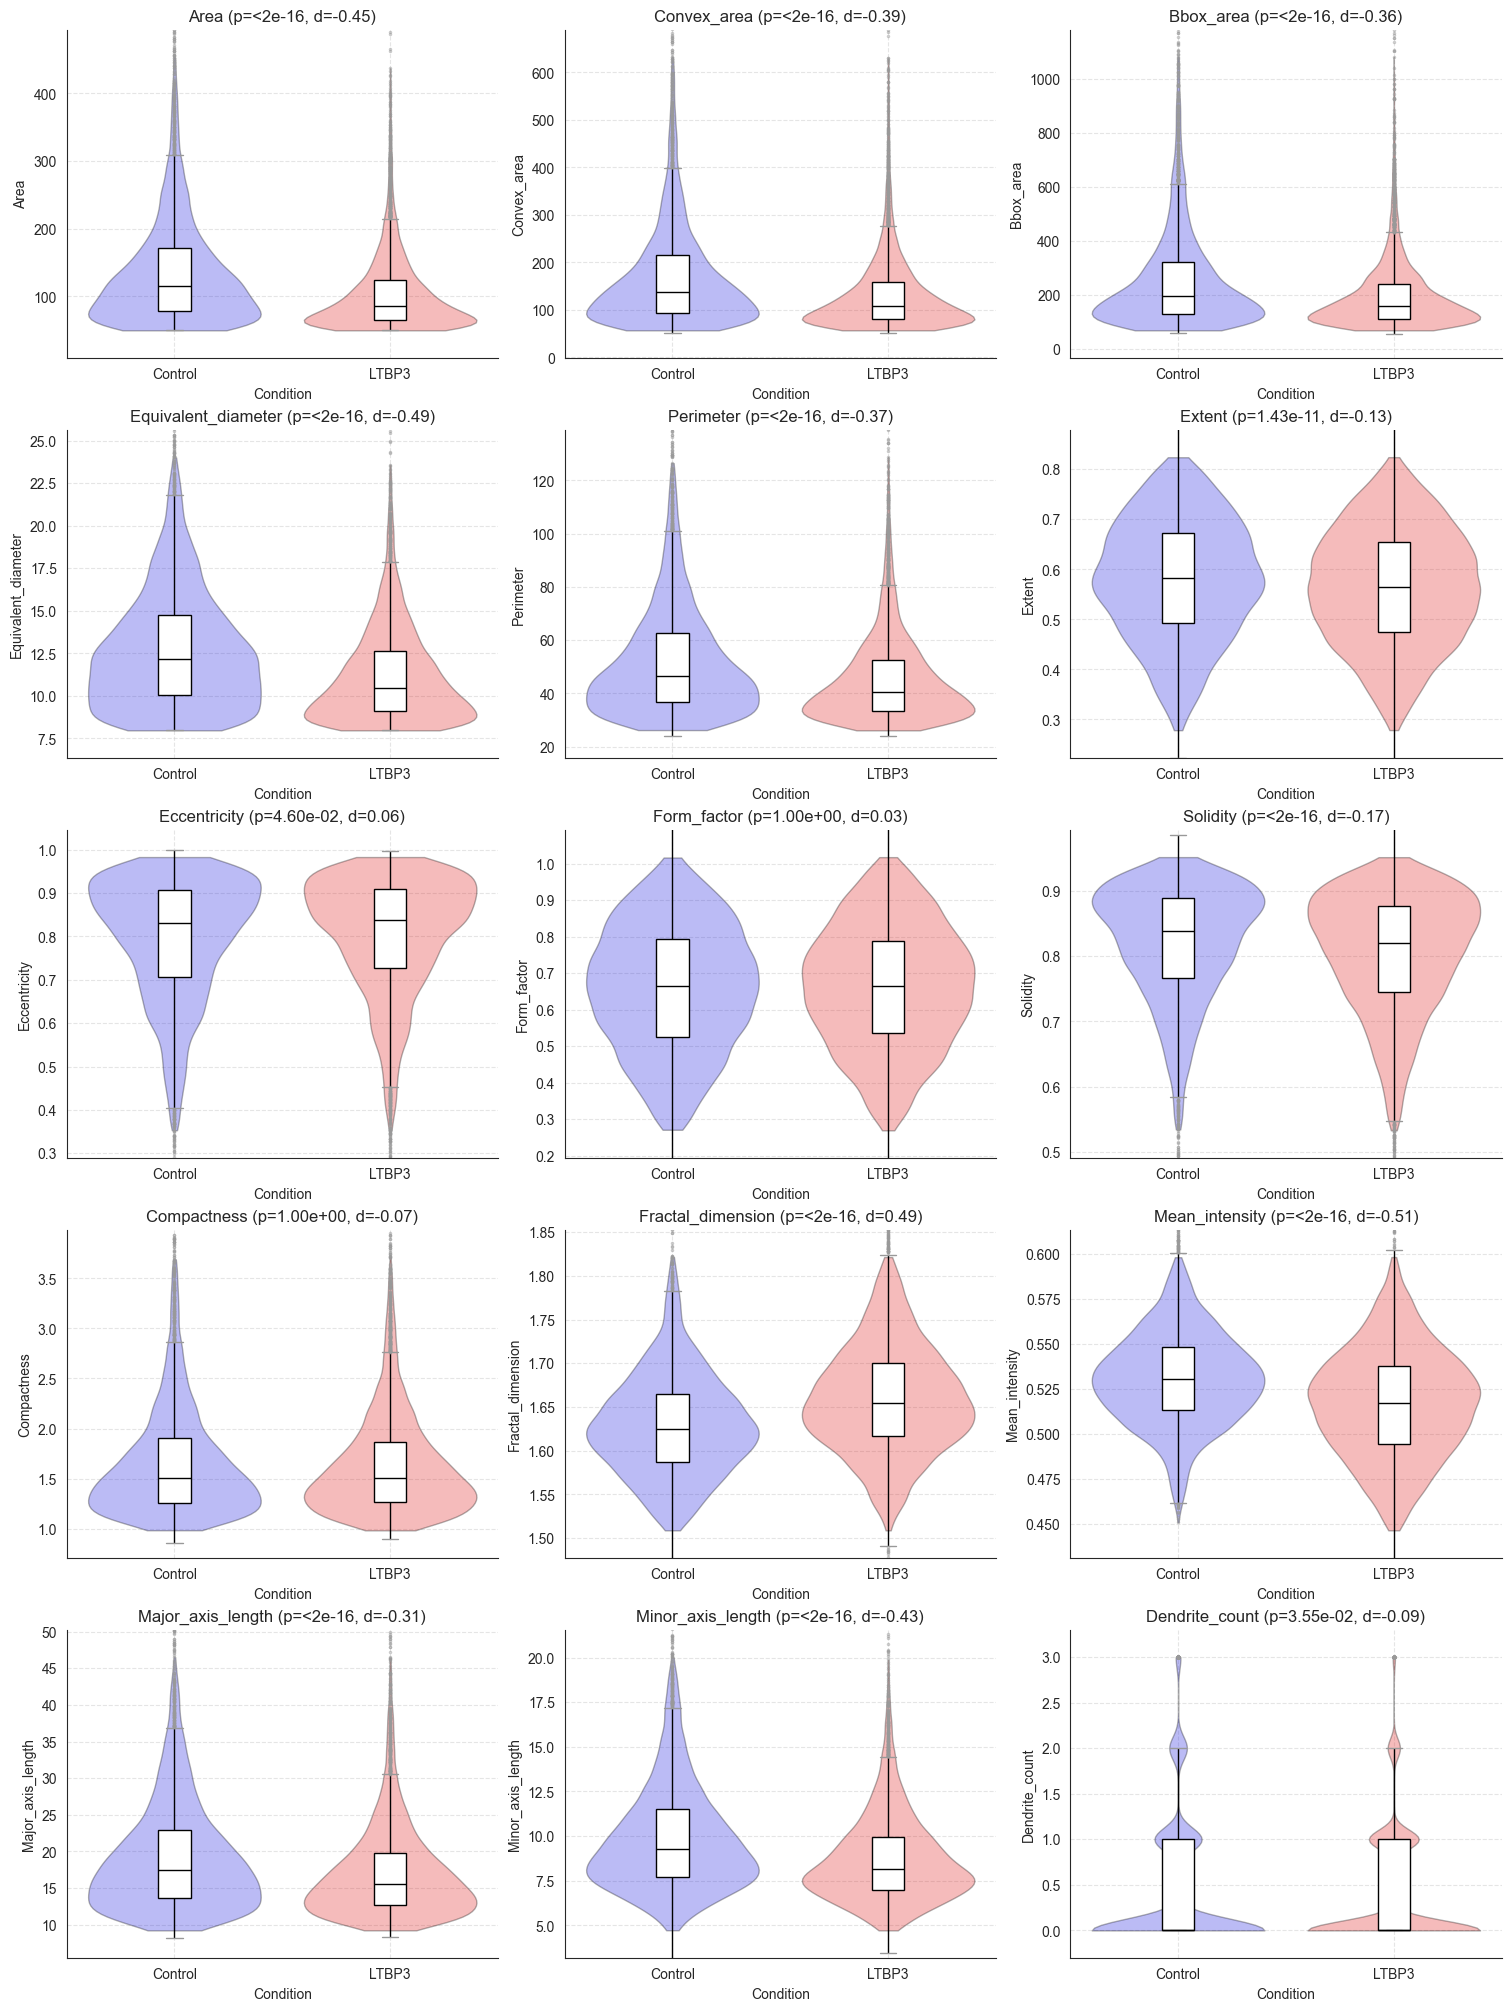

In [11]:
try:
    sns.set_style('white')
    fig, axes = plt.subplots(5, 3, figsize=(15, 20), constrained_layout=True)
    axes = axes.flatten()
    for i, feature in enumerate(features):
        p_adj = stats_df[stats_df['Feature'] == feature]['Adjusted p-value'].values[0]
        d = stats_df[stats_df['Feature'] == feature]["Cohen's d"].values[0]
        p_str = '<2e-16' if p_adj < 2e-16 else f'{p_adj:.2e}'
        d_str = f'{d:.2f}' if not np.isnan(d) else 'N/A'
        data = df_features[[feature, 'condition']].copy()
        q_low, q_high = data[feature].quantile([0.01, 0.99])
        data_filtered = data[(data[feature] >= q_low) & (data[feature] <= q_high)]
        sns.violinplot(data=data_filtered, x='condition', y=feature, hue='condition', ax=axes[i], inner=None, cut=0, alpha=0.3, 
                       linewidth=1, edgecolor='black', palette={'Control': 'blue', 'LTBP3': 'red'})
        sns.boxplot(data=df_features, x='condition', y=feature, ax=axes[i], width=0.15, color='white', fliersize=3, 
                    flierprops={'marker': '.', 'alpha': 0.5, 'color': 'black'}, whiskerprops={'color': 'black', 'linewidth': 1}, 
                    boxprops={'edgecolor': 'black', 'linewidth': 1}, medianprops={'color': 'black', 'linewidth': 1})
        axes[i].set_ylim(q_low - 0.1 * (q_high - q_low), q_high + 0.1 * (q_high - q_low))
        axes[i].set_title(f'{feature.capitalize()} (p={p_str}, d={d_str})', fontsize=12)
        axes[i].set_xlabel('Condition', fontsize=10)
        axes[i].set_ylabel(feature.capitalize(), fontsize=10)
        axes[i].grid(True, linestyle='--', alpha=0.5)
        sns.despine(ax=axes[i])
    plt.suptitle('Morphology Feature Distributions: Control vs. LTBP3-Deficient Cells', fontsize=16, y=1.02)
    plt.savefig(morph_dir / 'violin_box_plots.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    print('Interpretation:')
    print('Violin-box plots show feature distributions, with LTBP3-deficient cells often having higher means for size (area, perimeter) and branching (dendrite_count, fractal_dimension) features. Significant p-values and large Cohen’s d indicate robust differences. Outliers suggest heterogeneous cell responses or imaging artifacts.')
except Exception as e:
    print(f'Error in feature distribution analysis: {e}')

## 10. Conclusions

**Summary**:
- **Hypertrophy**: LTBP3-deficient cells show significantly larger area, perimeter, convex_area, bbox_area, and equivalent_diameter (p<0.05, large Cohen’s d), confirming hypertrophy due to disrupted TGF-β signaling.
- **Branching**: Higher dendrite_count and fractal_dimension in LTBP3-deficient cells indicate enhanced dendritic branching, affecting cell communication in the lacuno-canalicular network.
- **Temporal Dynamics**: Cell tracking and time series plots reveal greater morphological variability in LTBP3-deficient cells, suggesting dynamic cytoskeletal remodeling.
- **Correlations**: Strong correlations between size metrics (e.g., area vs. convex_area) and branching metrics (e.g., dendrite_count vs. fractal_dimension) indicate redundant features and linked biological processes.
- **PCA and Clustering**: Partial separation in PCA space and distinct clusters suggest morphological heterogeneity, with LTBP3-deficient cells forming subgroups due to altered morphology.

**Biological Insights**:
- Hypertrophy likely results from altered TGF-β-mediated cytoskeletal organization, leading to increased cell spreading.
- Enhanced branching (higher dendrite_count, fractal_dimension) suggests increased mechanosensing capacity, potentially compensating for signaling deficits.
- Temporal variability indicates dynamic responses to LTBP3 deficiency, possibly linked to bone remodeling dysregulation.

**Recommendations for future research**:
- Include 3D imaging in future studies for accurate dendrite counting.
- Perform molecular assays to link morphology to TGF-β pathway genes.
- Validate outliers via manual inspection to confirm biological relevance.